<h1>Technical Test: B.	Anomaly Detection Modelling and Pipeline Design (Applicable for Data Scientist/AI Engineer Candidate(s) Only) 
    by Lim Thian Kiat
    
<h1>Introduction

The objective of this program is to analyse the wafer sensor tool data and derive meaningful insights from the data. The sensor data may be able to identify whether the sensor tools are working properly or not. If the sensors show abnormality, then there may be an indicator that the tool sensor is faulty or needs maintenance.<br>
This program will follow the following steps to process the sensor data:

1.	Data preprocessing
2.	Feature engineering
3.	Feature selection
4.	Hyperparameter tuning
5.	Model training
6.	Model prediction
7.	Anomaly detection

At the end of the program, we should be able to identify which are the important features to monitor (in real-time) to ensure it triggers an alert when there is an abnormality with the tool sensor during a wafer run.

<h1>1. Data Preprocesing

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt 

<h2>1.1 Data Collection and Importing

In [2]:
# Read the CSV data into a Pandas DataFrame, please update the path according to your local storage path
df = pd.read_csv('D:\\Download\\Tool_Sensor_Data.csv')

<h2>1.2 Data Exploration

In [3]:
print(df.shape)
df.head()

(14844, 90)


TimeStamp ToolName TOOL_ID    Run RunStartTime  DATA_QUALITY EQPType  \
0  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
1  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
2  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
3  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
4  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   

   HasComments LOT_ID LogicalRecipeID  ... yqScxEFPLde jrsnDLYHnMHD  \
0            0      A               A  ...         NaN          NaN   
1            0      A               A  ...         NaN          NaN   
2            0      A               A  ...         NaN          NaN   
3            0      A               A  ...         NaN          NaN   
4            0      A               A  ...         NaN          NaN   

  CalcStepSeq CalcLoopSeq RunTag Unnamed: 85 Unnamed: 86 Unnamed: 87  \
0         NaN         NaN    NaN         NaN         NaN         NaN   
1         1.0         1.0    NaN         NaN         NaN         NaN   
2         2.0         2.0    NaN         NaN         NaN         NaN   
3         3.0         3.0    NaN         NaN         NaN         NaN   
4         4.0         4.0    NaN         NaN         NaN         NaN   

  Unnamed: 88  Unnamed: 89  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 90 columns]

The shape of the data is 14,844 rows with 90 columns. The summary of five rows shows various types of data are available inside the raw data. For the data to be processed by the Machine Learning algorithm, it is best if all the data are in numbers instead of strings. Many NaN show that there is missing data, and data cleaning is necessary as a normal process.

<h2>1.3 Data Cleaning

<h3>1.3.1 Remove Duplicated Rows and Manual Removal

In [4]:
# Remove Duplicated Rows, the timeline helps to ensure duplicated rows would not be removed wrongly
print('Before = ', df.shape)
df = df.drop_duplicates()
print('After = ', df.shape)

Before =  (14844, 90)
After =  (14113, 90)


In [5]:
# The TimeStamp indicates it is time series data, but since it is not a sales transaction, it may not be useful.
# The more important info is the Run number for identifying which Wafer Run is good or abnormal.
if 'TimeStamp' in df.columns:
    df = df.drop('TimeStamp', axis=1)
if 'RunStartTime' in df.columns:
    df = df.drop('RunStartTime', axis=1)

<h3>1.3.2 Convert Single Character to Integer

In [6]:
# Unsure if ToolName, RecipeID is useful or not, just convert the character into integer and evaluate later
# Define the function to convert character to number
def char_to_num(char):
    return ord(char) - 64

single_char_columns = [col for col in df.columns if all(len(str(val)) == 1 for val in df[col])]

for column in single_char_columns:
    if df[column].dtypes == 'object':
        df[column] = df[column].apply(char_to_num)

In [7]:
# Verify the result of the converstion and cleaning
print(df.shape)
df.head()

(14113, 88)


ToolName  TOOL_ID    Run  DATA_QUALITY  EQPType  HasComments  LOT_ID  \
0         1        1  62301         63.49        1            0       1   
1         1        1  62301         63.49        1            0       1   
2         1        1  62301         63.49        1            0       1   
3         1        1  62301         63.49        1            0       1   
4         1        1  62301         63.49        1            0       1   

   LogicalRecipeID LotPurposeType     LotType  ...  yqScxEFPLde  jrsnDLYHnMHD  \
0                1    Process Lot  Production  ...          NaN           NaN   
1                1    Process Lot  Production  ...          NaN           NaN   
2                1    Process Lot  Production  ...          NaN           NaN   
3                1    Process Lot  Production  ...          NaN           NaN   
4                1    Process Lot  Production  ...          NaN           NaN   

   CalcStepSeq  CalcLoopSeq  RunTag  Unnamed: 85  Unnamed: 86  Unnamed: 87  \
0          NaN          NaN     NaN          NaN          NaN          NaN   
1          1.0          1.0     NaN          NaN          NaN          NaN   
2          2.0          2.0     NaN          NaN          NaN          NaN   
3          3.0          3.0     NaN          NaN          NaN          NaN   
4          4.0          4.0     NaN          NaN          NaN          NaN   

   Unnamed: 88  Unnamed: 89  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN  

[5 rows x 88 columns]

<h3>1.3.3 Remove non-integer columns

In [8]:
# Find/Check for any other non-integer columns
for column in df.columns:
    if df[column].dtypes == 'object':
        print('column name =',column, 'type =', df[column].dtypes, 'content =', df[column].iloc[0])

column name = LotPurposeType type = object content = Process Lot
column name = LotType type = object content = Production
column name = EventType type = object content = StartOfRun
column name = EventName type = object content = WaferStart
column name = EventId type = object content = WaferStart


In [9]:
# Verify manually if those columns are not useful (no value for ML), drop it
for column in df.columns:
    if df[column].dtypes == 'object':
        print(column, df[column].dtypes, '= DROP')
        df = df.drop(column, axis=1)

LotPurposeType object = DROP
LotType object = DROP
EventType object = DROP
EventName object = DROP
EventId object = DROP


In [10]:
# Verify the cleaning result
print(df.shape)
df.head()

(14113, 83)


ToolName  TOOL_ID    Run  DATA_QUALITY  EQPType  HasComments  LOT_ID  \
0         1        1  62301         63.49        1            0       1   
1         1        1  62301         63.49        1            0       1   
2         1        1  62301         63.49        1            0       1   
3         1        1  62301         63.49        1            0       1   
4         1        1  62301         63.49        1            0       1   

   LogicalRecipeID  MachineRecipeID  PhysicalRecipeID  ...  yqScxEFPLde  \
0                1                1                 1  ...          NaN   
1                1                1                 1  ...          NaN   
2                1                1                 1  ...          NaN   
3                1                1                 1  ...          NaN   
4                1                1                 1  ...          NaN   

   jrsnDLYHnMHD  CalcStepSeq  CalcLoopSeq  RunTag  Unnamed: 85  Unnamed: 86  \
0           NaN          NaN          NaN     NaN          NaN          NaN   
1           NaN          1.0          1.0     NaN          NaN          NaN   
2           NaN          2.0          2.0     NaN          NaN          NaN   
3           NaN          3.0          3.0     NaN          NaN          NaN   
4           NaN          4.0          4.0     NaN          NaN          NaN   

   Unnamed: 87  Unnamed: 88  Unnamed: 89  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN  

[5 rows x 83 columns]

<h3>1.3.4 Remove blank or useless Rows

In [11]:
# Calculate how many cells inside a row is filled with data
non_empty_columns_per_row = df.count(axis=1)
non_empty_columns_per_row

0        18
1        66
2        66
3        66
4        66
         ..
14839    66
14840    66
14841    66
14842    66
14843    21
Length: 14113, dtype: int64

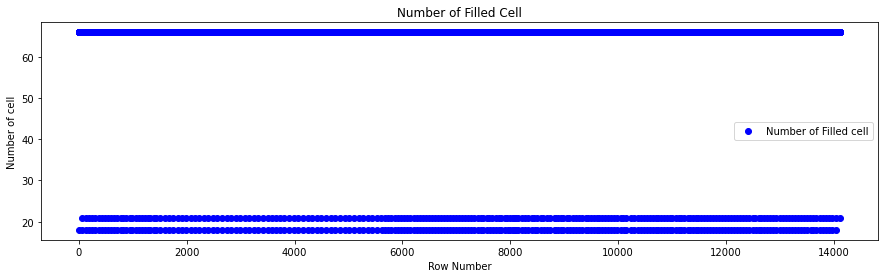

In [12]:
# Visualise the Rows with Numbers vs Rows without Numbers/Empty
# Generate x-coordinates as a sequence of numbers
x_data = list(range(1, len(non_empty_columns_per_row) + 1))

# Create a scatter plot
plt.figure(figsize=(15, 4))
plt.scatter(x_data, non_empty_columns_per_row, marker='o', color='blue', label='Number of Filled cell')

# Add labels and a title
plt.xlabel('Row Number')
plt.ylabel('Number of cell')
plt.title('Number of Filled Cell')

# Show the legend
plt.legend()

# Show the plot
plt.show()

Those with very few filled cell, which means it has many empty cells, shows that the row does not have much value for ML.

In [13]:
# Pick a cut off threshold, in this case, based on the chart above, we can pick the centre point
print('Total length = ', len(df.columns))
threshold = len(df.columns)/2
print('Threshold =', threshold)

Total length =  83
Threshold = 41.5


In [14]:
# Remove empty rows below the threshold
print('Before remove=',df.shape)
df = df.dropna(thresh=threshold)
print('After remove=',df.shape)

Before remove= (14113, 83)
After remove= (13657, 83)


In [15]:
# Verify Removal of Empty Rows is completed successfully
non_empty_columns_per_row = df.count(axis=1)
non_empty_columns_per_row

1        66
2        66
3        66
4        66
5        66
         ..
14838    66
14839    66
14840    66
14841    66
14842    66
Length: 13657, dtype: int64

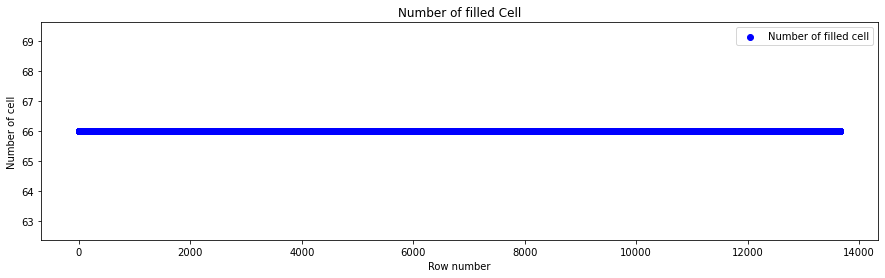

In [16]:
# Visualise the Rows with Numbers vs Rows without Numbers/Empty
# Generate x-coordinates as a sequence of numbers
x_data = list(range(1, len(non_empty_columns_per_row) + 1))

# Create a scatter plot
plt.figure(figsize=(15, 4))
plt.scatter(x_data, non_empty_columns_per_row, marker='o', color='blue', label='Number of filled cell')

# Add labels and a title
plt.xlabel('Row number')
plt.ylabel('Number of cell')
plt.title('Number of filled Cell')

# Show the legend
plt.legend()

# Show the plot
plt.show()

<h3>1.3.5 Remove Duplicate Row, Empty Columns or Useless Columns

In [17]:
# Remove duplicates again?
#print(df.shape)
#df = df.drop_duplicates()
#print(df.shape)
#(13657, 83)
#(13652, 83)
# Not to run as not sure what rows been removed. 

In [18]:
# Fill in empty cells with Zero? Number zero allows calculation of standard deviation
df = df.fillna(0)
df.head()

ToolName  TOOL_ID    Run  DATA_QUALITY  EQPType  HasComments  LOT_ID  \
1         1        1  62301         63.49        1            0       1   
2         1        1  62301         63.49        1            0       1   
3         1        1  62301         63.49        1            0       1   
4         1        1  62301         63.49        1            0       1   
5         1        1  62301         63.49        1            0       1   

   LogicalRecipeID  MachineRecipeID  PhysicalRecipeID  ...  yqScxEFPLde  \
1                1                1                 1  ...          0.0   
2                1                1                 1  ...          0.0   
3                1                1                 1  ...          0.0   
4                1                1                 1  ...          0.0   
5                1                1                 1  ...          0.0   

   jrsnDLYHnMHD  CalcStepSeq  CalcLoopSeq  RunTag  Unnamed: 85  Unnamed: 86  \
1           0.0          1.0          1.0     0.0          0.0          0.0   
2           0.0          2.0          2.0     0.0          0.0          0.0   
3           0.0          3.0          3.0     0.0          0.0          0.0   
4           0.0          4.0          4.0     0.0          0.0          0.0   
5           0.0          5.0          5.0     0.0          0.0          0.0   

   Unnamed: 87  Unnamed: 88  Unnamed: 89  
1          0.0          0.0          0.0  
2          0.0          0.0          0.0  
3          0.0          0.0          0.0  
4          0.0          0.0          0.0  
5          0.0          0.0          0.0  

[5 rows x 83 columns]

In [19]:
# Remove Useless Columns by using standard deviation check, likely those columns are zeros/emtpy or having same value.
column_stddev = {}
for column in df.columns:
    std_deviation = df[column].std()
    if std_deviation == 0:
        print(column, std_deviation, "= DROP")
        df = df.drop(column, axis=1)
    else:
        column_stddev[column]=std_deviation

ToolName 0.0 = DROP
TOOL_ID 0.0 = DROP
EQPType 0.0 = DROP
HasComments 0.0 = DROP
LogicalRecipeID 0.0 = DROP
ReticleID 0.0 = DROP
GPTmghByqMSY 0.0 = DROP
pZXcGFNpzPf 0.0 = DROP
EHVtYhnRGb 0.0 = DROP
XSOeMfJAB 0.0 = DROP
SYklrMAXe 0.0 = DROP
jQVGDTFl 0.0 = DROP
YDlkDLfFEEi 0.0 = DROP
CYiycrAoYbg 0.0 = DROP
oUWQRhjudAd 0.0 = DROP
WTcLPnkDtRwBuCou 0.0 = DROP
EventSource 0.0 = DROP
EventDescription 0.0 = DROP
AlarmCode 0.0 = DROP
AlarmStatus 0.0 = DROP
VcnDxeRWVfK 0.0 = DROP
HxXxxvS 0.0 = DROP
LqnSjZtcJs 0.0 = DROP
vmZiUljnYP 0.0 = DROP
yqScxEFPLde 0.0 = DROP
jrsnDLYHnMHD 0.0 = DROP
RunTag 0.0 = DROP
Unnamed: 85 0.0 = DROP
Unnamed: 86 0.0 = DROP
Unnamed: 87 0.0 = DROP
Unnamed: 88 0.0 = DROP
Unnamed: 89 0.0 = DROP


In [20]:
# Verify the cleaning result
print(df.shape)
df.head()

(13657, 51)


Run  DATA_QUALITY  LOT_ID  MachineRecipeID  PhysicalRecipeID  PortID  \
1  62301         63.49       1                1                 1       1   
2  62301         63.49       1                1                 1       1   
3  62301         63.49       1                1                 1       1   
4  62301         63.49       1                1                 1       1   
5  62301         63.49       1                1                 1       1   

   ProcessOpNum  ProductGrpID  ProductID  RECIPE_ID  ...  YATWcaRqpB  \
1             1             1          1          1  ...         0.0   
2             1             1          1          1  ...         5.0   
3             1             1          1          1  ...         4.0   
4             1             1          1          1  ...         3.0   
5             1             1          1          1  ...         2.0   

   nJdvUmCcjI  NACdQXDDBP  NyUITkJtCGK  QesumGN  ETcatZBXS  RnVvcKsHhDEyb  \
1         0.0         0.0         0.74      2.0      500.0           81.0   
2      1304.0      3110.0         0.74      7.0      300.0           81.0   
3      1305.0      3107.0         0.74      8.0      300.0           81.0   
4      1302.0      3104.0         0.74      9.0     6200.0           81.0   
5      1302.0      3103.0         0.74     11.0     1400.0           81.0   

   tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  CalcLoopSeq  
1                         -25.0          1.0          1.0  
2                        1890.0          2.0          2.0  
3                        1890.0          3.0          3.0  
4                        1890.0          4.0          4.0  
5                        1890.0          5.0          5.0  

[5 rows x 51 columns]

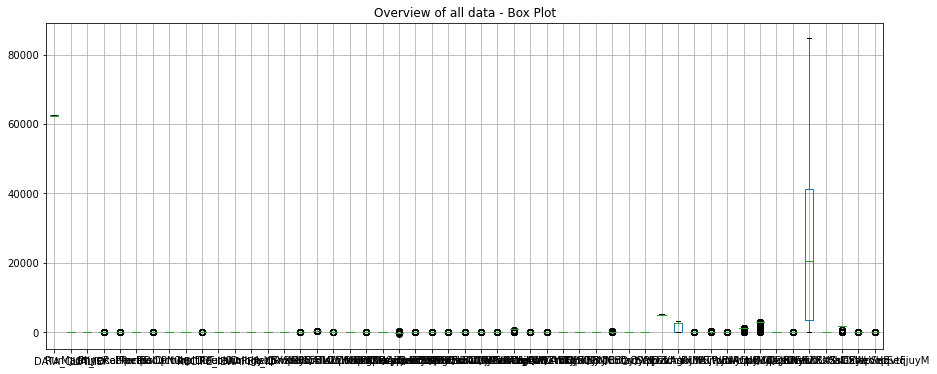

In [21]:
# Overview of the dataframe after preprocessing
# Define your desired figure size, e.g., (10, 6) for a 10x6-inch plot
fig, ax = plt.subplots(figsize=(15, 6))

# Create the boxplot
df.boxplot(ax=ax)

# You can also add a title to the plot if needed
plt.title('Overview of all data - Box Plot')

# Finally, display the plot in the Jupyter Notebook
plt.show()

In [22]:
# Save a copy of the clean dataframe
df_clean=df.copy()
df.to_csv('d:\\download\\1.3_Cleaning.csv', index=False)

<h1>2. Feature Engineering

<h2>2.1 Visualise current data/features

Column =  Run
1        62301
2        62301
3        62301
4        62301
5        62301
         ...  
14838    62600
14839    62600
14840    62600
14841    62600
14842    62600
Name: Run, Length: 13657, dtype: int64


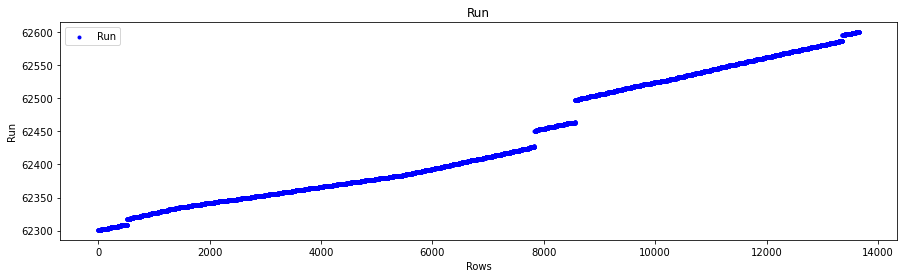

Column =  DATA_QUALITY
1        63.49
2        63.49
3        63.49
4        63.49
5        63.49
         ...  
14838    70.28
14839    70.28
14840    70.28
14841    70.28
14842    70.28
Name: DATA_QUALITY, Length: 13657, dtype: float64


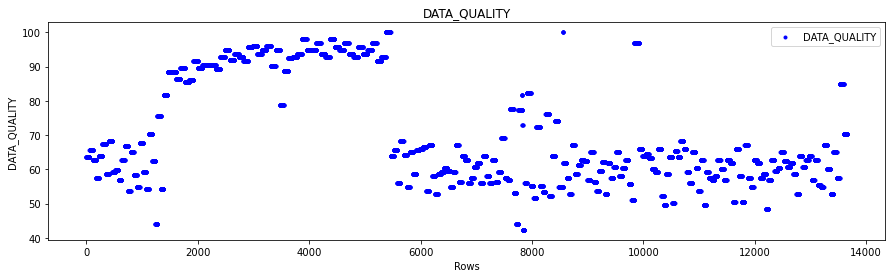

Column =  LOT_ID
1         1
2         1
3         1
4         1
5         1
         ..
14838    23
14839    23
14840    23
14841    23
14842    23
Name: LOT_ID, Length: 13657, dtype: int64


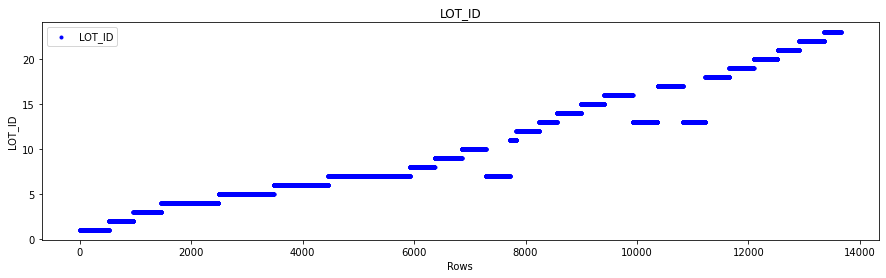

Column =  MachineRecipeID
1        1
2        1
3        1
4        1
5        1
        ..
14838    1
14839    1
14840    1
14841    1
14842    1
Name: MachineRecipeID, Length: 13657, dtype: int64


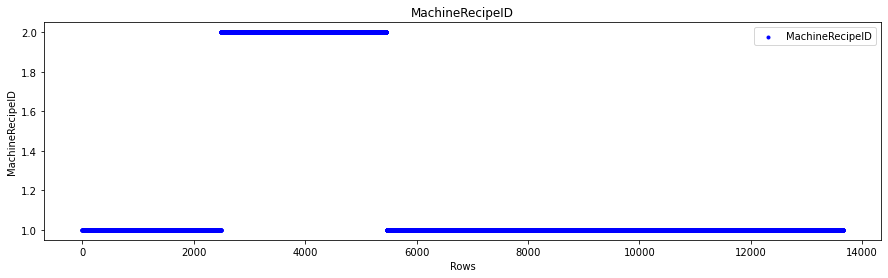

Column =  PhysicalRecipeID
1        1
2        1
3        1
4        1
5        1
        ..
14838    1
14839    1
14840    1
14841    1
14842    1
Name: PhysicalRecipeID, Length: 13657, dtype: int64


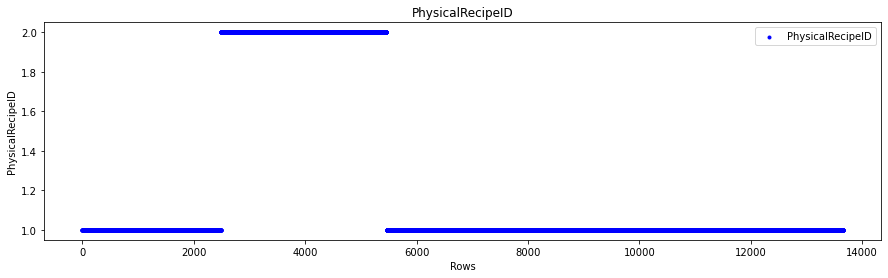

Column =  PortID
1        1
2        1
3        1
4        1
5        1
        ..
14838    2
14839    2
14840    2
14841    2
14842    2
Name: PortID, Length: 13657, dtype: int64


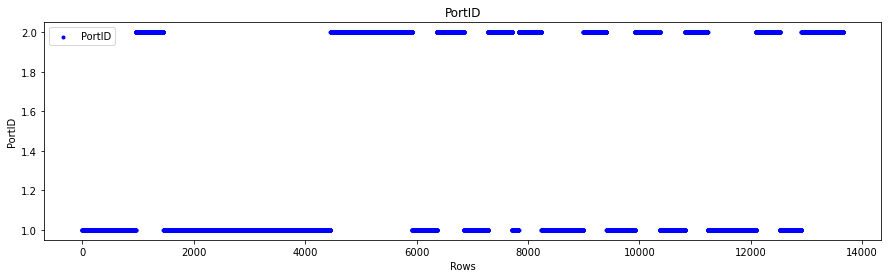

Column =  ProcessOpNum
1        1
2        1
3        1
4        1
5        1
        ..
14838    1
14839    1
14840    1
14841    1
14842    1
Name: ProcessOpNum, Length: 13657, dtype: int64


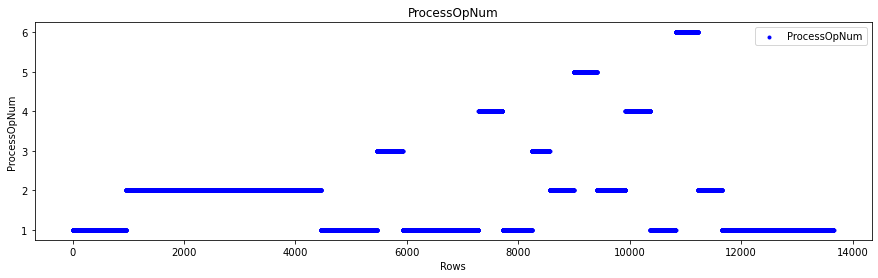

Column =  ProductGrpID
1         1
2         1
3         1
4         1
5         1
         ..
14838    14
14839    14
14840    14
14841    14
14842    14
Name: ProductGrpID, Length: 13657, dtype: int64


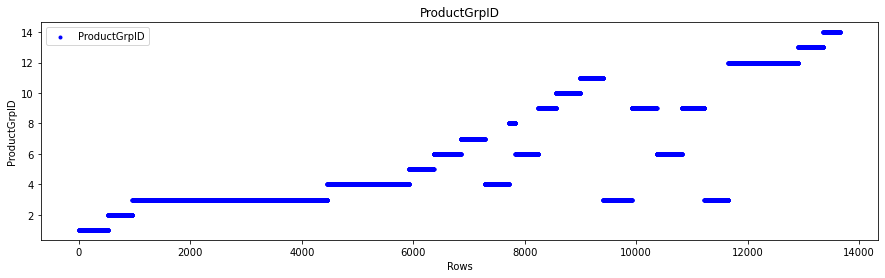

Column =  ProductID
1         1
2         1
3         1
4         1
5         1
         ..
14838    16
14839    16
14840    16
14841    16
14842    16
Name: ProductID, Length: 13657, dtype: int64


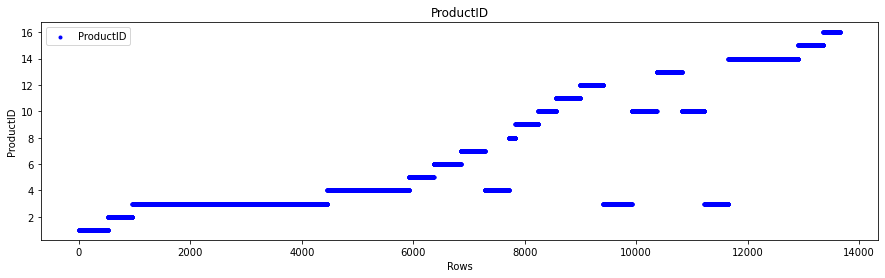

Column =  RECIPE_ID
1        1
2        1
3        1
4        1
5        1
        ..
14838    1
14839    1
14840    1
14841    1
14842    1
Name: RECIPE_ID, Length: 13657, dtype: int64


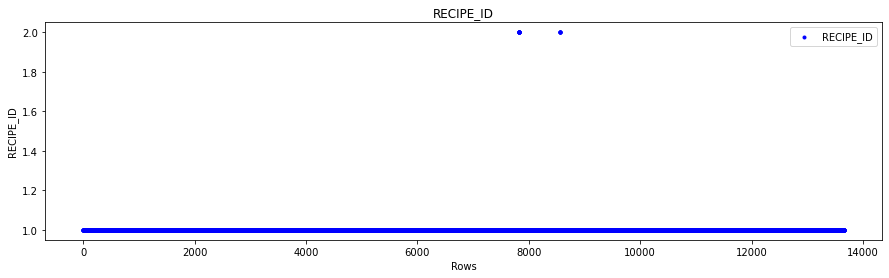

Column =  RouteID
1         1
2         1
3         1
4         1
5         1
         ..
14838    12
14839    12
14840    12
14841    12
14842    12
Name: RouteID, Length: 13657, dtype: int64


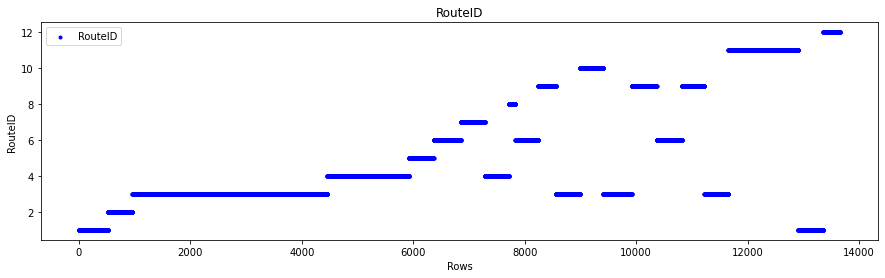

Column =  Technology
1        1
2        1
3        1
4        1
5        1
        ..
14838    2
14839    2
14840    2
14841    2
14842    2
Name: Technology, Length: 13657, dtype: int64


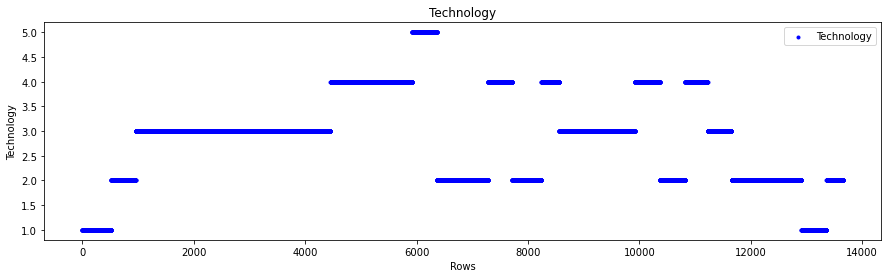

Column =  WAFER_ID
1         1
2         1
3         1
4         1
5         1
         ..
14838    15
14839    15
14840    15
14841    15
14842    15
Name: WAFER_ID, Length: 13657, dtype: int64


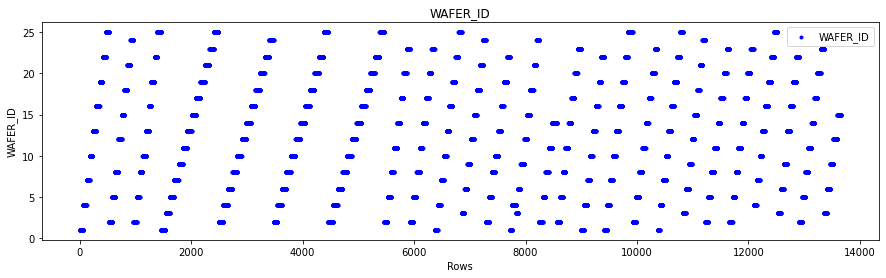

Column =  OunhHslCRwIRilo
1         56.0
2        148.0
3         12.0
4         19.0
5        100.0
         ...  
14838    153.0
14839    155.0
14840    159.0
14841    159.0
14842    157.0
Name: OunhHslCRwIRilo, Length: 13657, dtype: float64


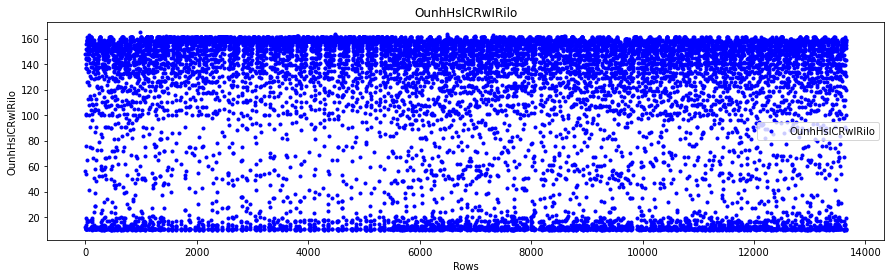

Column =  iezpXSIRyQ
1        0.98
2        0.98
3        0.98
4        0.98
5        0.98
         ... 
14838    0.98
14839    0.98
14840    0.98
14841    0.98
14842    0.98
Name: iezpXSIRyQ, Length: 13657, dtype: float64


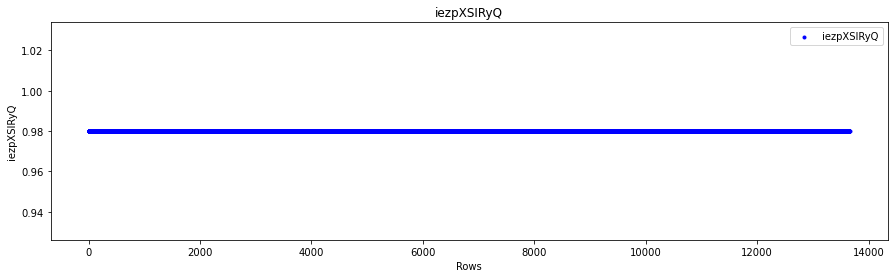

Column =  BmpcKiosIw
1        0.71
2        3.76
3        4.17
4        4.44
5        4.66
         ... 
14838    4.42
14839    4.32
14840    4.22
14841    4.20
14842    4.25
Name: BmpcKiosIw, Length: 13657, dtype: float64


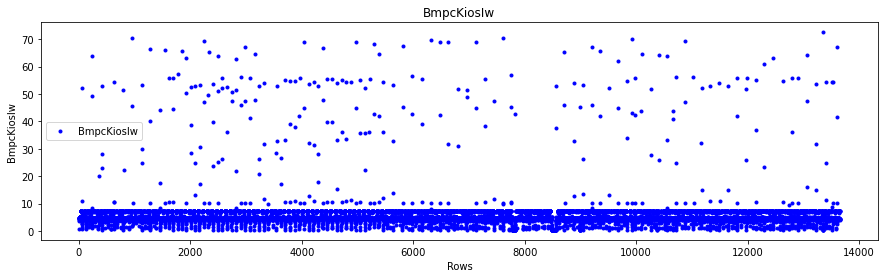

Column =  XnKsCBLOqH
1        306.0
2        308.0
3        307.0
4        307.0
5        307.0
         ...  
14838    348.0
14839    315.0
14840    313.0
14841    315.0
14842    369.0
Name: XnKsCBLOqH, Length: 13657, dtype: float64


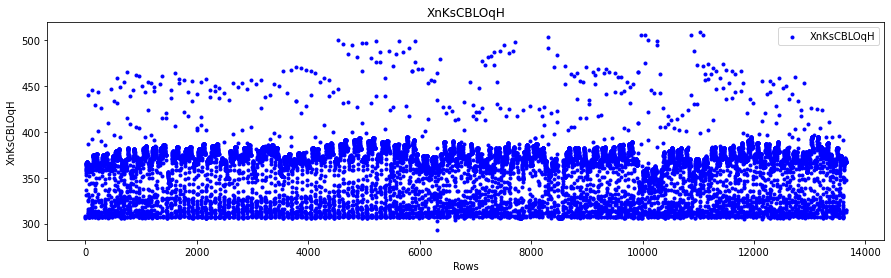

Column =  GEErHMkWtLOrD
1        119.0
2        119.0
3        120.0
4        119.0
5        119.0
         ...  
14838    121.0
14839    121.0
14840    121.0
14841    121.0
14842    121.0
Name: GEErHMkWtLOrD, Length: 13657, dtype: float64


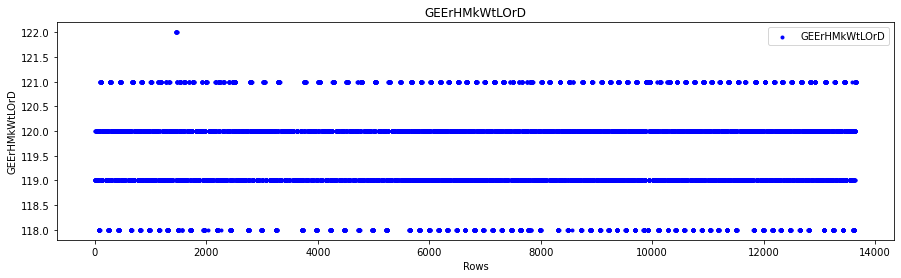

Column =  ATisLDMDDfZrI
1        129.0
2        128.0
3        128.0
4        127.0
5        127.0
         ...  
14838    130.0
14839    131.0
14840    131.0
14841    131.0
14842    131.0
Name: ATisLDMDDfZrI, Length: 13657, dtype: float64


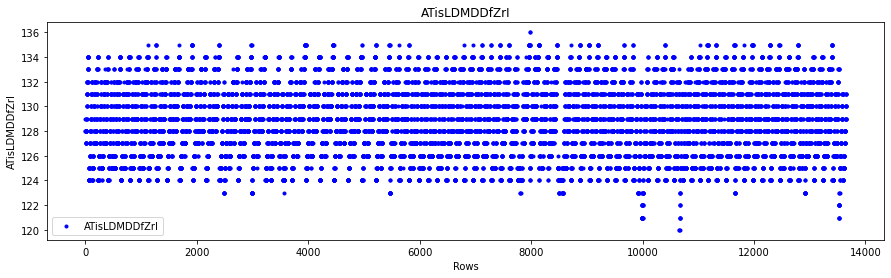

Column =  ZhitvZfLGQzyC
1        145.0
2        144.0
3        144.0
4        144.0
5        145.0
         ...  
14838    147.0
14839    147.0
14840    148.0
14841    148.0
14842    148.0
Name: ZhitvZfLGQzyC, Length: 13657, dtype: float64


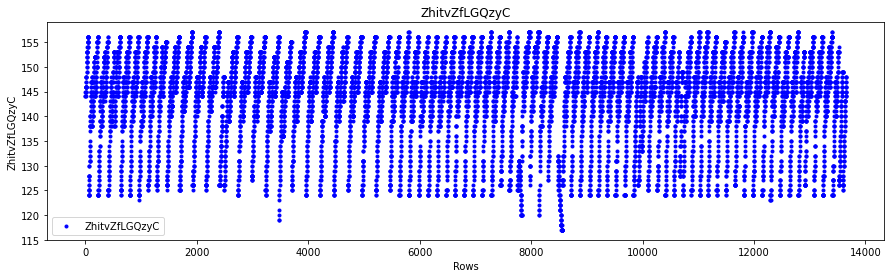

Column =  SwpYipezsdueC
1        125.0
2        123.0
3        123.0
4        123.0
5        123.0
         ...  
14838    138.0
14839    139.0
14840    138.0
14841    138.0
14842    137.0
Name: SwpYipezsdueC, Length: 13657, dtype: float64


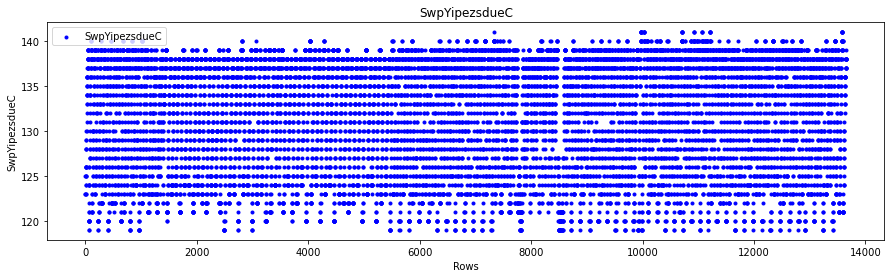

Column =  YiAwOaAhwskZcEfg
1         3.0
2       -72.0
3       -72.0
4       -72.0
5       -72.0
         ... 
14838   -88.0
14839     4.0
14840     2.0
14841     3.0
14842     6.0
Name: YiAwOaAhwskZcEfg, Length: 13657, dtype: float64


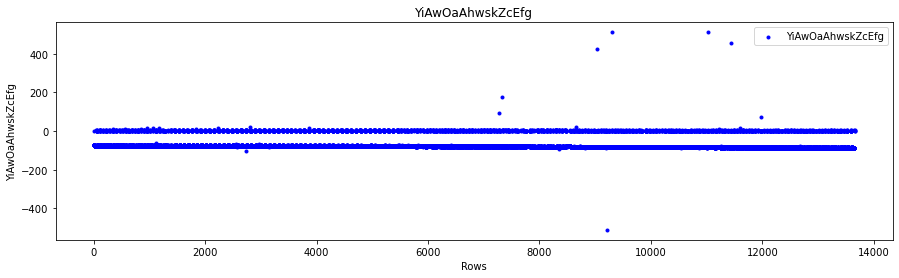

Column =  CxPgKZCqQsFtMQZdEkFTQ
1        3.0
2        3.0
3        3.0
4        3.0
5        3.0
        ... 
14838    3.0
14839    3.0
14840    3.0
14841    3.0
14842    3.0
Name: CxPgKZCqQsFtMQZdEkFTQ, Length: 13657, dtype: float64


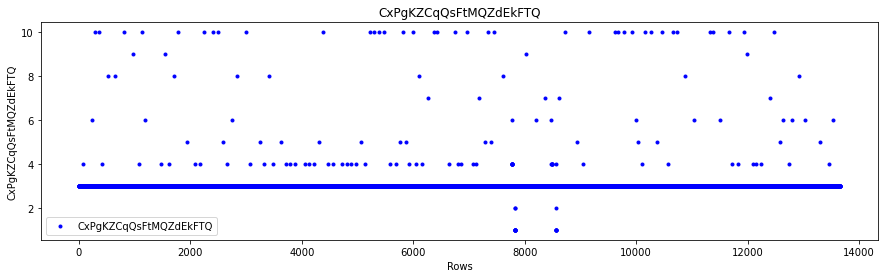

Column =  EcBnlzqiTwFxSSBTvYsYOOaCax
1        0.0
2        0.0
3        0.2
4        1.8
5        0.7
        ... 
14838    0.1
14839    0.0
14840    0.0
14841    0.0
14842    0.0
Name: EcBnlzqiTwFxSSBTvYsYOOaCax, Length: 13657, dtype: float64


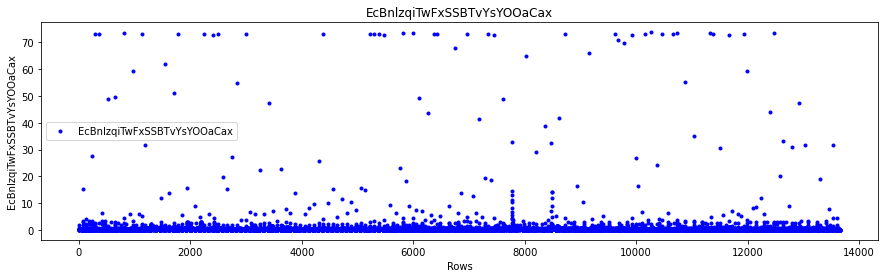

Column =  UYmpqidlVJQGSXnENDNUVUTbp
1        7.00
2        7.00
3        6.83
4        7.00
5        7.00
         ... 
14838    7.00
14839    7.00
14840    7.00
14841    7.00
14842    7.00
Name: UYmpqidlVJQGSXnENDNUVUTbp, Length: 13657, dtype: float64


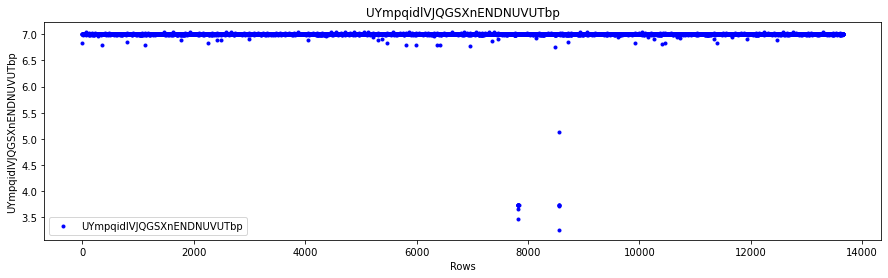

Column =  QveHzspDQenotLMRwWdjK
1        5.85
2        5.84
3        5.85
4        6.45
5        6.33
         ... 
14838    6.33
14839    5.86
14840    5.84
14841    5.84
14842    5.85
Name: QveHzspDQenotLMRwWdjK, Length: 13657, dtype: float64


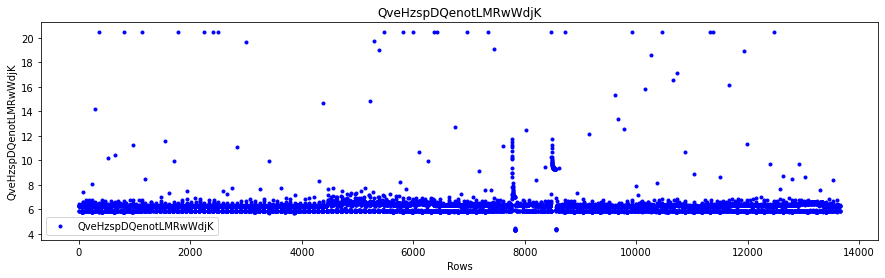

Column =  tzEiBNrESroInUjAStFCzgiCYU
1        0.00
2        0.00
3        0.01
4        0.61
5        0.49
         ... 
14838    0.52
14839    0.00
14840    0.00
14841    0.00
14842    0.00
Name: tzEiBNrESroInUjAStFCzgiCYU, Length: 13657, dtype: float64


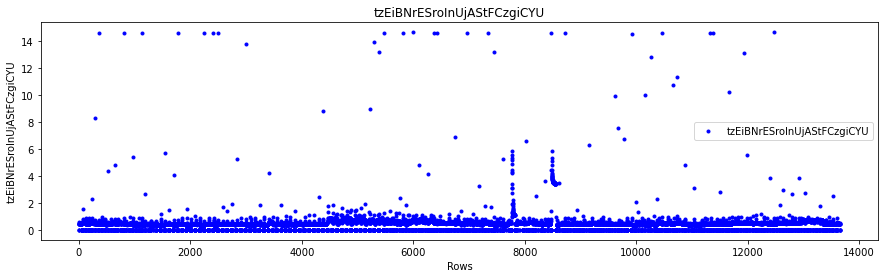

Column =  OeFBBIdvVlvVTeDufgEbQZtuB
1        9.49
2        9.49
3        9.63
4        9.49
5        9.49
         ... 
14838    9.49
14839    9.49
14840    9.49
14841    9.49
14842    9.49
Name: OeFBBIdvVlvVTeDufgEbQZtuB, Length: 13657, dtype: float64


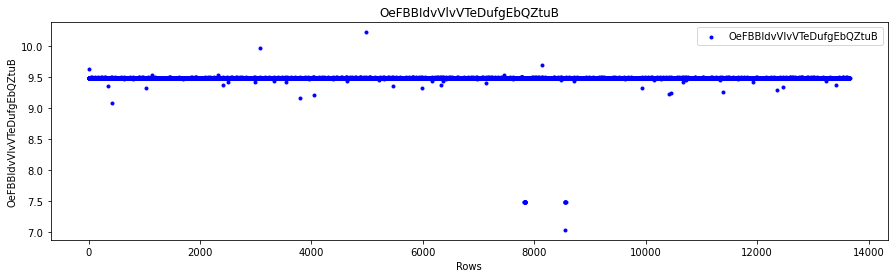

Column =  TyPUktVeQlH
1         13.0
2        968.0
3        968.0
4        968.0
5        968.0
         ...  
14838    953.0
14839     14.0
14840     14.0
14841     14.0
14842     14.0
Name: TyPUktVeQlH, Length: 13657, dtype: float64


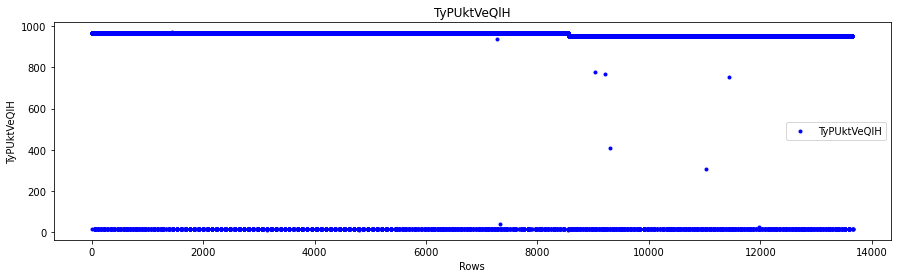

Column =  ArsbiQzICA
1         99.0
2        111.0
3        111.0
4        111.0
5        111.0
         ...  
14838    111.0
14839    111.0
14840    111.0
14841    111.0
14842    111.0
Name: ArsbiQzICA, Length: 13657, dtype: float64


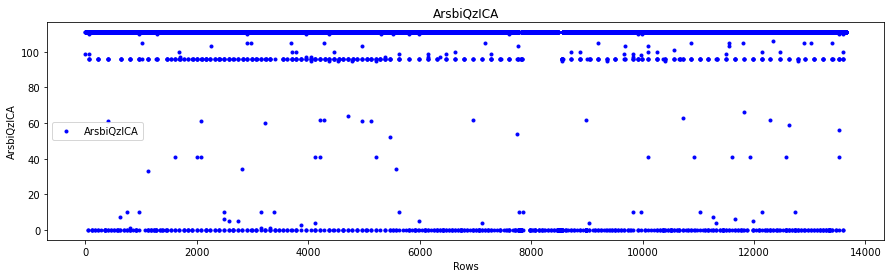

Column =  ueAWtcWKJJ
1         6.46
2        16.03
3        16.06
4        16.06
5        16.06
         ...  
14838    16.03
14839    16.03
14840    16.06
14841    16.03
14842    16.03
Name: ueAWtcWKJJ, Length: 13657, dtype: float64


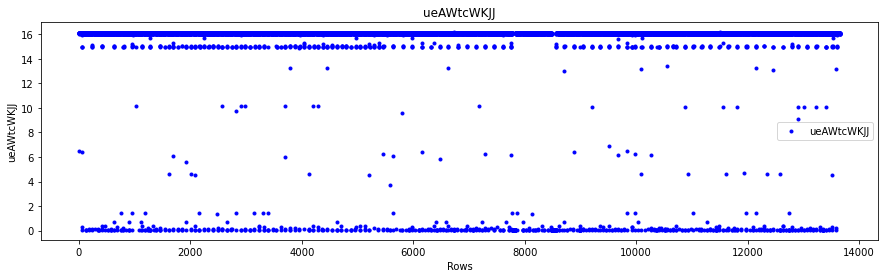

Column =  WLGtKKqZiN
1          0.0
2        127.0
3        127.0
4         86.0
5        106.0
         ...  
14838    127.0
14839    127.0
14840    127.0
14841    127.0
14842    127.0
Name: WLGtKKqZiN, Length: 13657, dtype: float64


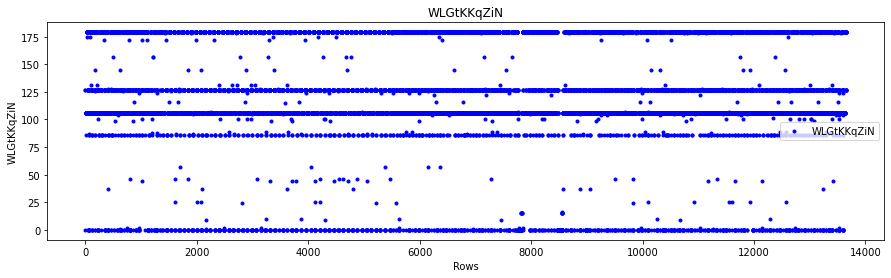

Column =  YffEHvEJjM
1         0.0
2         0.0
3        35.0
4        40.0
5        49.0
         ... 
14838     0.0
14839     0.0
14840     0.0
14841     0.0
14842     0.0
Name: YffEHvEJjM, Length: 13657, dtype: float64


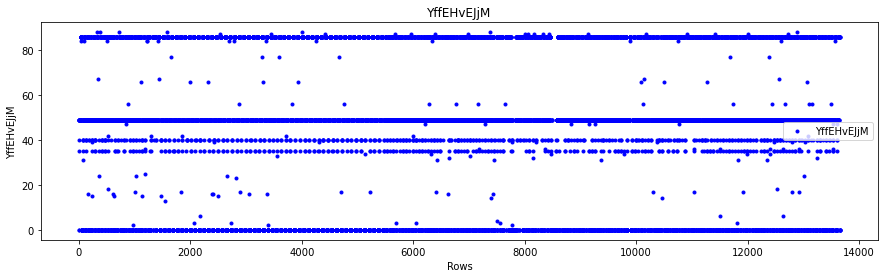

Column =  TNfKYBQBdc
1        0.00
2        0.00
3        4.04
4        7.05
5        9.15
         ... 
14838    0.02
14839    0.00
14840    0.01
14841    0.01
14842    0.01
Name: TNfKYBQBdc, Length: 13657, dtype: float64


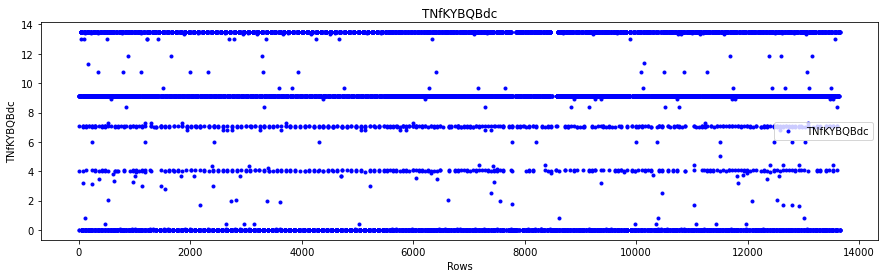

Column =  ETYSQPkJNbQsmWtwf
1         98.0
2        200.0
3        206.0
4        199.0
5        201.0
         ...  
14838    212.0
14839    210.0
14840    209.0
14841    208.0
14842    204.0
Name: ETYSQPkJNbQsmWtwf, Length: 13657, dtype: float64


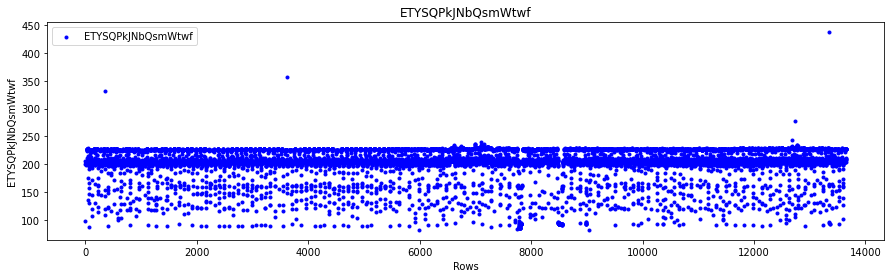

Column =  dCEQyYYpj
1        2.47
2        2.47
3        2.47
4        2.47
5        2.47
         ... 
14838    2.13
14839    2.13
14840    2.13
14841    2.13
14842    2.13
Name: dCEQyYYpj, Length: 13657, dtype: float64


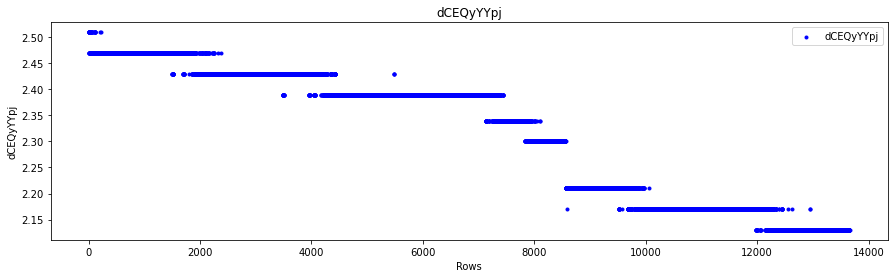

Column =  taQyPEGv
1        0.738
2        0.738
3        0.738
4        0.738
5        0.738
         ...  
14838    0.738
14839    0.738
14840    0.738
14841    0.738
14842    0.738
Name: taQyPEGv, Length: 13657, dtype: float64


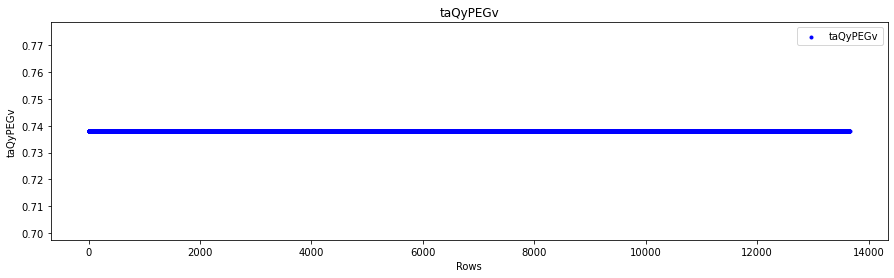

Column =  dSqlDZohVx
1        4852.0
2        4852.0
3        4852.0
4        4852.0
5        4852.0
          ...  
14838    5151.0
14839    5151.0
14840    5151.0
14841    5151.0
14842    5151.0
Name: dSqlDZohVx, Length: 13657, dtype: float64


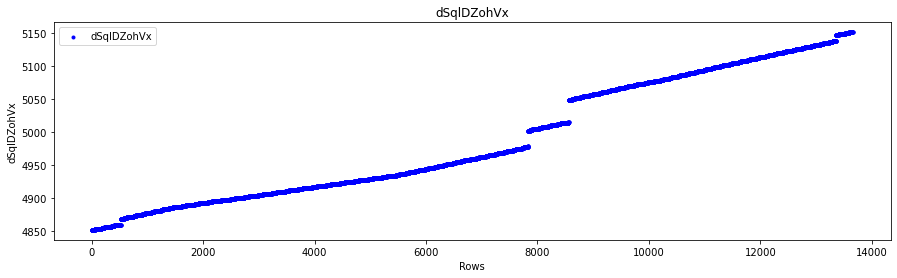

Column =  pIzvhgujbH
1           1.0
2           1.0
3           1.0
4        1251.0
5        2651.0
          ...  
14838     514.0
14839       1.0
14840       1.0
14841       1.0
14842       1.0
Name: pIzvhgujbH, Length: 13657, dtype: float64


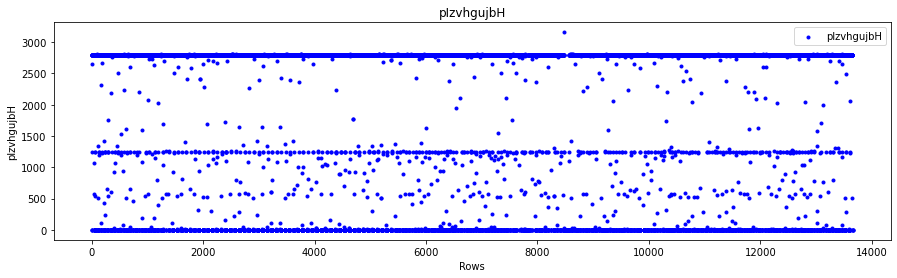

Column =  XAsiHMsvPv
1         0.0
2         0.0
3         0.0
4         0.0
5        63.0
         ... 
14838     5.0
14839     0.0
14840     1.0
14841     0.0
14842     1.0
Name: XAsiHMsvPv, Length: 13657, dtype: float64


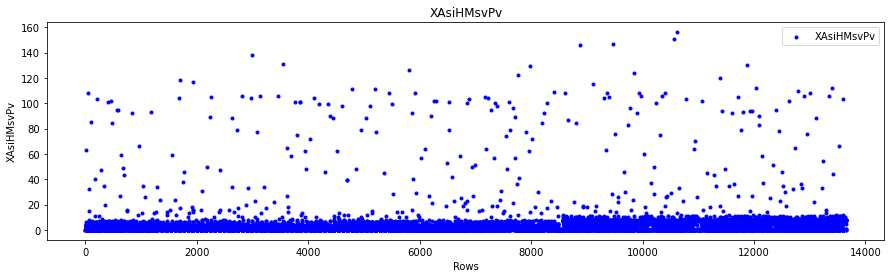

Column =  RUNSjtpEAy
1         0.0
2        12.0
3         8.0
4         6.0
5         4.0
         ... 
14838     9.0
14839    12.0
14840     2.0
14841     2.0
14842     1.0
Name: RUNSjtpEAy, Length: 13657, dtype: float64


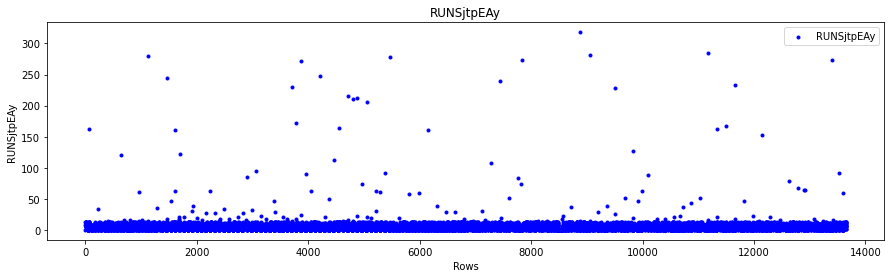

Column =  YATWcaRqpB
1        0.0
2        5.0
3        4.0
4        3.0
5        2.0
        ... 
14838    7.0
14839    2.0
14840    2.0
14841    2.0
14842    2.0
Name: YATWcaRqpB, Length: 13657, dtype: float64


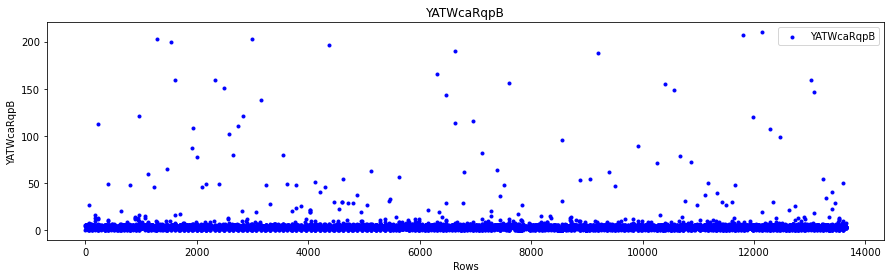

Column =  nJdvUmCcjI
1           0.0
2        1304.0
3        1305.0
4        1302.0
5        1302.0
          ...  
14838    1306.0
14839    1001.0
14840    1001.0
14841    1001.0
14842    1045.0
Name: nJdvUmCcjI, Length: 13657, dtype: float64


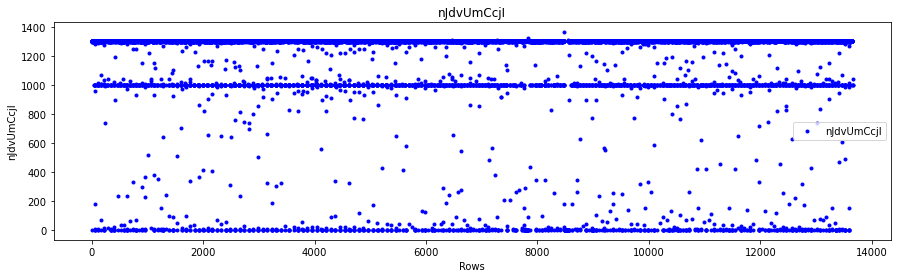

Column =  NACdQXDDBP
1           0.0
2        3110.0
3        3107.0
4        3104.0
5        3103.0
          ...  
14838    3108.0
14839    2013.0
14840    2005.0
14841    2005.0
14842    2003.0
Name: NACdQXDDBP, Length: 13657, dtype: float64


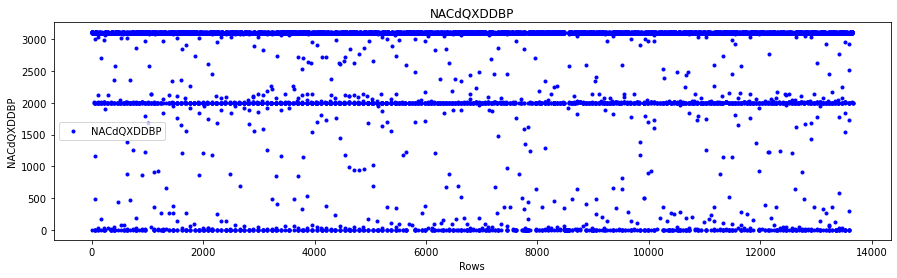

Column =  NyUITkJtCGK
1        0.74
2        0.74
3        0.74
4        0.74
5        0.74
         ... 
14838    0.74
14839    0.74
14840    0.74
14841    0.74
14842    0.74
Name: NyUITkJtCGK, Length: 13657, dtype: float64


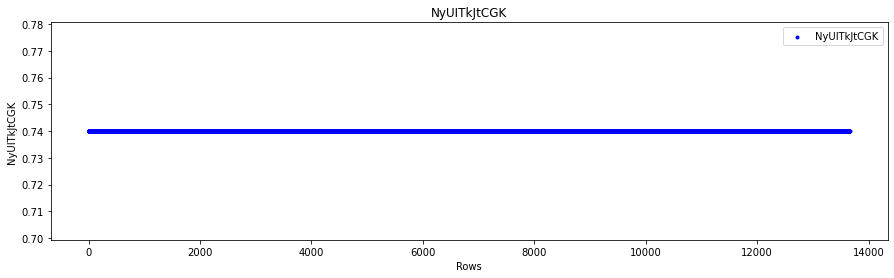

Column =  QesumGN
1         2.0
2         7.0
3         8.0
4         9.0
5        11.0
         ... 
14838    19.0
14839    21.0
14840    22.0
14841    22.0
14842    23.0
Name: QesumGN, Length: 13657, dtype: float64


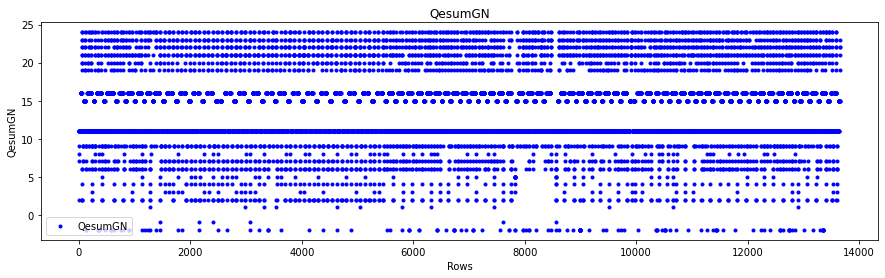

Column =  ETcatZBXS
1         500.0
2         300.0
3         300.0
4        6200.0
5        1400.0
          ...  
14838    2900.0
14839     700.0
14840     700.0
14841    3000.0
14842    4600.0
Name: ETcatZBXS, Length: 13657, dtype: float64


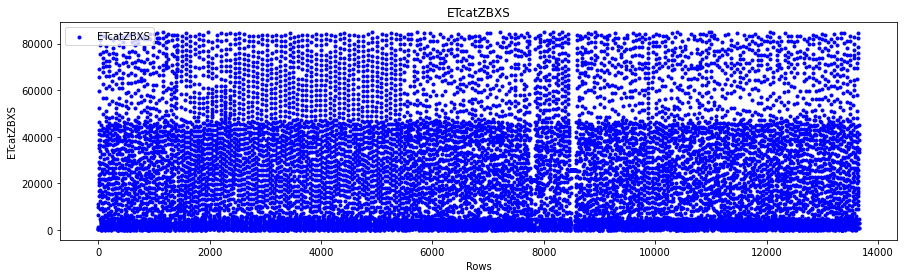

Column =  RnVvcKsHhDEyb
1         81.0
2         81.0
3         81.0
4         81.0
5         81.0
         ...  
14838    114.0
14839    114.0
14840    114.0
14841    114.0
14842    114.0
Name: RnVvcKsHhDEyb, Length: 13657, dtype: float64


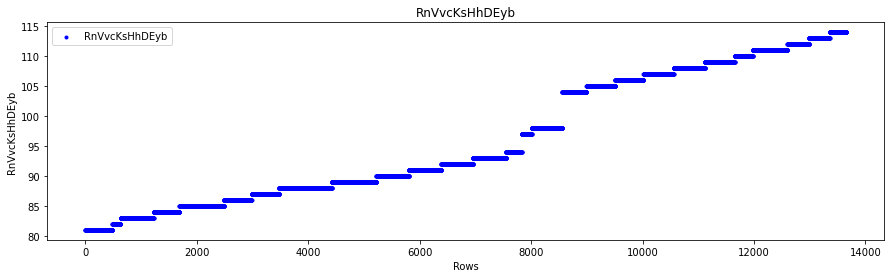

Column =  tMqophNywoUtXsGZAeVHBvtFjuyM
1         -25.0
2        1890.0
3        1890.0
4        1890.0
5        1890.0
          ...  
14838    1890.0
14839    1890.0
14840    1890.0
14841    1890.0
14842    1890.0
Name: tMqophNywoUtXsGZAeVHBvtFjuyM, Length: 13657, dtype: float64


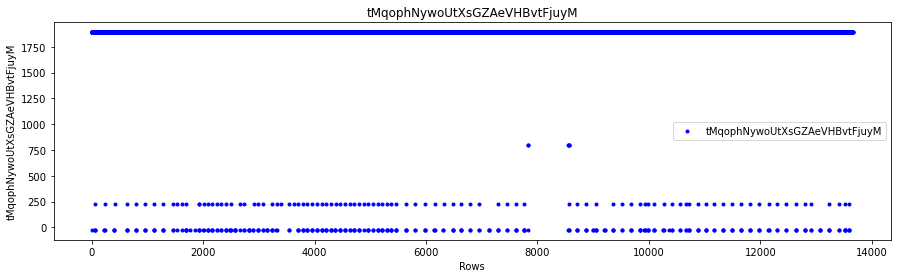

Column =  CalcStepSeq
1         1.0
2         2.0
3         3.0
4         4.0
5         5.0
         ... 
14838     9.0
14839    10.0
14840    11.0
14841    11.0
14842    12.0
Name: CalcStepSeq, Length: 13657, dtype: float64


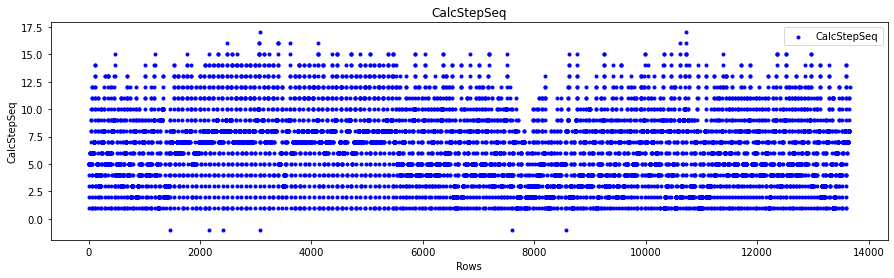

Column =  CalcLoopSeq
1         1.0
2         2.0
3         3.0
4         4.0
5         5.0
         ... 
14838     9.0
14839    10.0
14840    11.0
14841    11.0
14842    12.0
Name: CalcLoopSeq, Length: 13657, dtype: float64


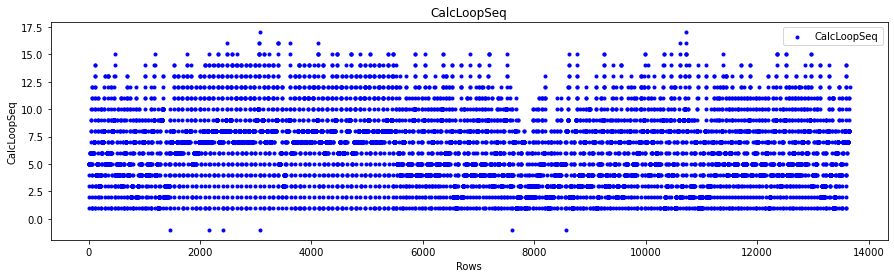

In [23]:
# Plot all column into chart to visualise the data, print out some content of data to inspect
# Jupyter -> Cell -> Current Output -> Toggle Scrolling (to enable/disable scrolling)
for column in df.columns:
    print('Column = ', column)
    print(df[column])
    
    # Generate x-coordinates as a sequence of numbers
    x_data = list(range(1, len(df[column]) + 1))

    # Create a scatter plot
    plt.figure(figsize=(15, 4))
    plt.scatter(x_data, df[column], marker='.', color='blue', label=column)

    # Add labels and a title
    plt.xlabel('Rows')
    plt.ylabel(column)
    plt.title(column)

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

<h3>2.1.1 Zoom in to visualise the details

Column =  Run
1       62301
2       62301
3       62301
4       62301
5       62301
        ...  
1058    62326
1059    62326
1060    62326
1061    62326
1062    62326
Name: Run, Length: 1000, dtype: int64


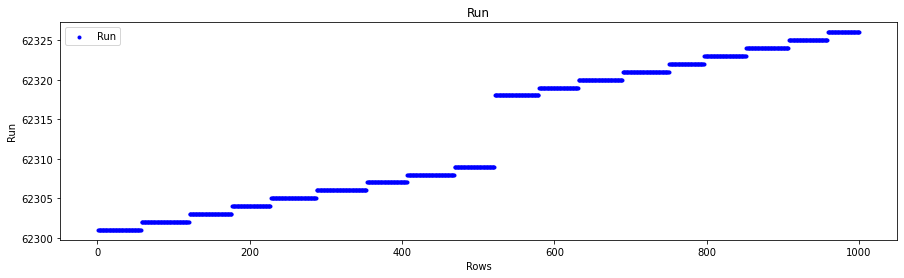

Column =  DATA_QUALITY
1       63.49
2       63.49
3       63.49
4       63.49
5       63.49
        ...  
1058    67.79
1059    67.79
1060    67.79
1061    67.79
1062    67.79
Name: DATA_QUALITY, Length: 1000, dtype: float64


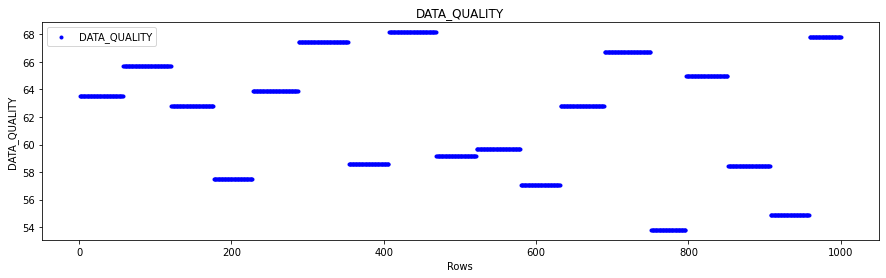

Column =  LOT_ID
1       1
2       1
3       1
4       1
5       1
       ..
1058    3
1059    3
1060    3
1061    3
1062    3
Name: LOT_ID, Length: 1000, dtype: int64


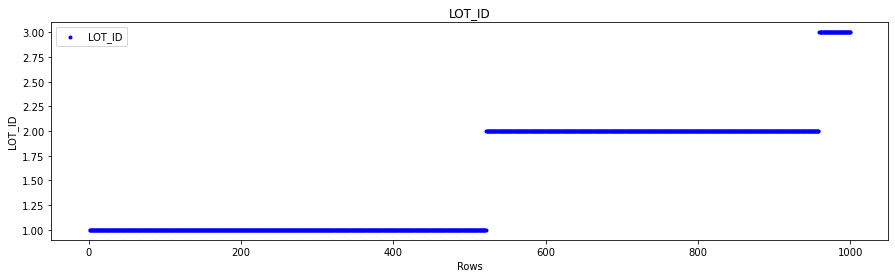

Column =  MachineRecipeID
1       1
2       1
3       1
4       1
5       1
       ..
1058    1
1059    1
1060    1
1061    1
1062    1
Name: MachineRecipeID, Length: 1000, dtype: int64


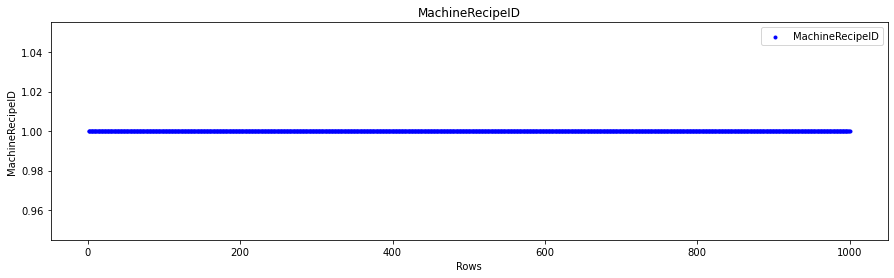

Column =  PhysicalRecipeID
1       1
2       1
3       1
4       1
5       1
       ..
1058    1
1059    1
1060    1
1061    1
1062    1
Name: PhysicalRecipeID, Length: 1000, dtype: int64


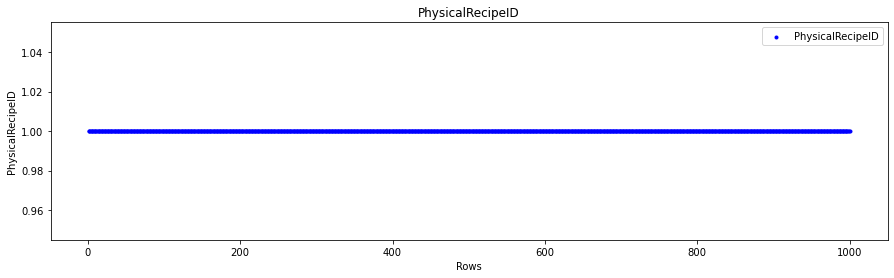

Column =  PortID
1       1
2       1
3       1
4       1
5       1
       ..
1058    2
1059    2
1060    2
1061    2
1062    2
Name: PortID, Length: 1000, dtype: int64


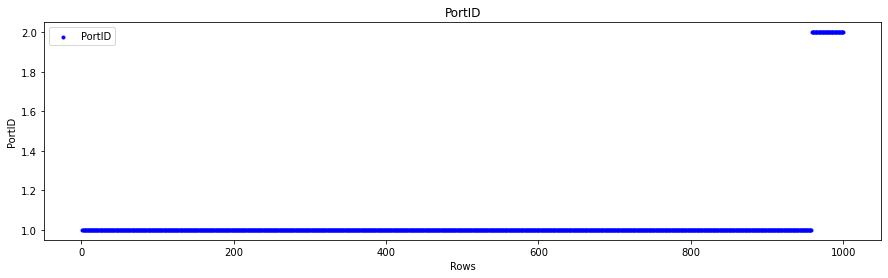

Column =  ProcessOpNum
1       1
2       1
3       1
4       1
5       1
       ..
1058    2
1059    2
1060    2
1061    2
1062    2
Name: ProcessOpNum, Length: 1000, dtype: int64


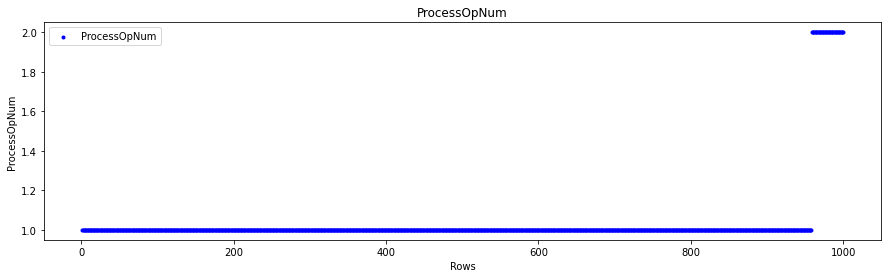

Column =  ProductGrpID
1       1
2       1
3       1
4       1
5       1
       ..
1058    3
1059    3
1060    3
1061    3
1062    3
Name: ProductGrpID, Length: 1000, dtype: int64


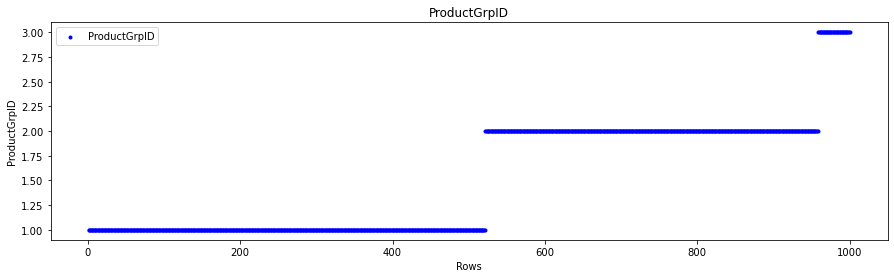

Column =  ProductID
1       1
2       1
3       1
4       1
5       1
       ..
1058    3
1059    3
1060    3
1061    3
1062    3
Name: ProductID, Length: 1000, dtype: int64


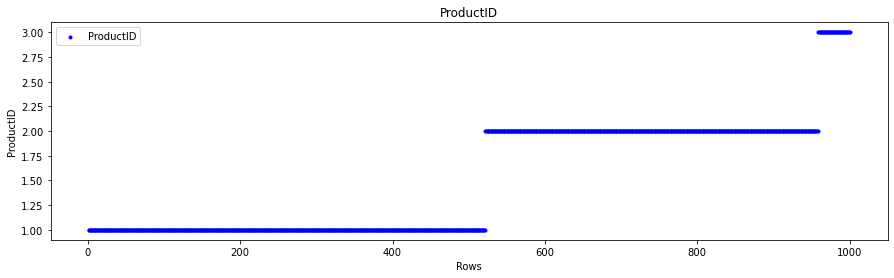

Column =  RECIPE_ID
1       1
2       1
3       1
4       1
5       1
       ..
1058    1
1059    1
1060    1
1061    1
1062    1
Name: RECIPE_ID, Length: 1000, dtype: int64


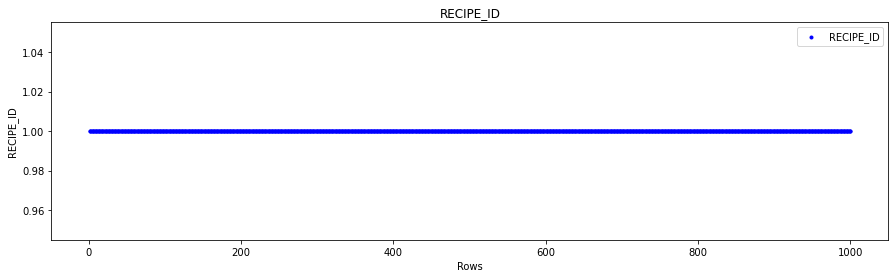

Column =  RouteID
1       1
2       1
3       1
4       1
5       1
       ..
1058    3
1059    3
1060    3
1061    3
1062    3
Name: RouteID, Length: 1000, dtype: int64


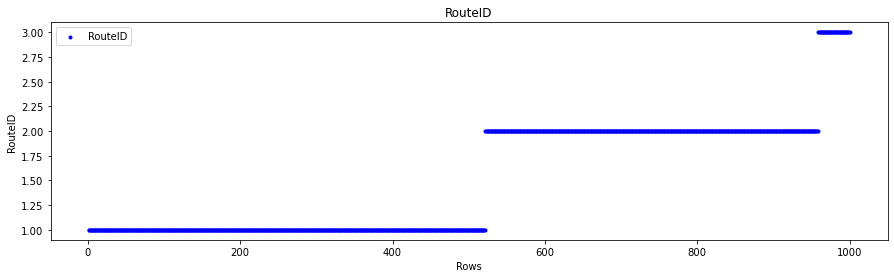

Column =  Technology
1       1
2       1
3       1
4       1
5       1
       ..
1058    3
1059    3
1060    3
1061    3
1062    3
Name: Technology, Length: 1000, dtype: int64


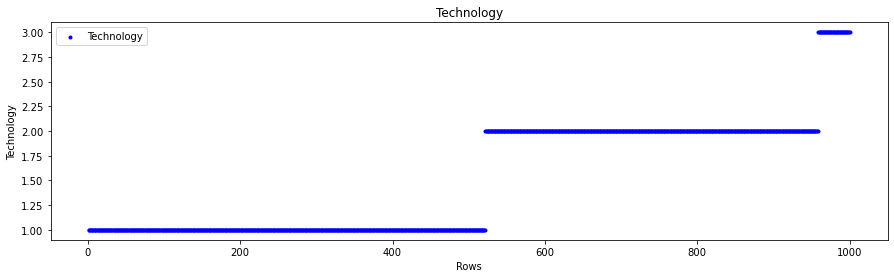

Column =  WAFER_ID
1       1
2       1
3       1
4       1
5       1
       ..
1058    2
1059    2
1060    2
1061    2
1062    2
Name: WAFER_ID, Length: 1000, dtype: int64


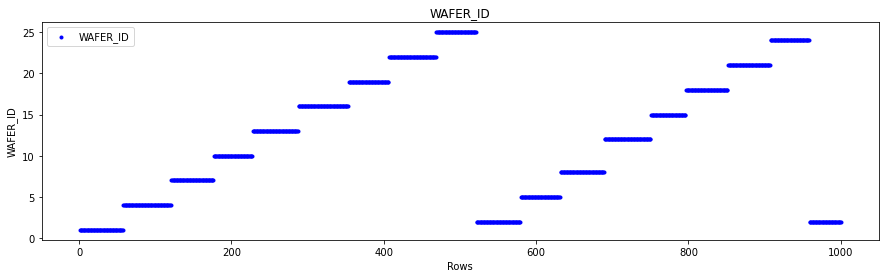

Column =  OunhHslCRwIRilo
1        56.0
2       148.0
3        12.0
4        19.0
5       100.0
        ...  
1058    159.0
1059    158.0
1060    159.0
1061    161.0
1062    158.0
Name: OunhHslCRwIRilo, Length: 1000, dtype: float64


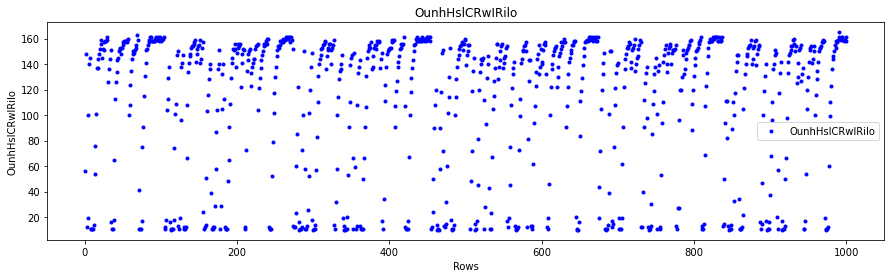

Column =  iezpXSIRyQ
1       0.98
2       0.98
3       0.98
4       0.98
5       0.98
        ... 
1058    0.98
1059    0.98
1060    0.98
1061    0.98
1062    0.98
Name: iezpXSIRyQ, Length: 1000, dtype: float64


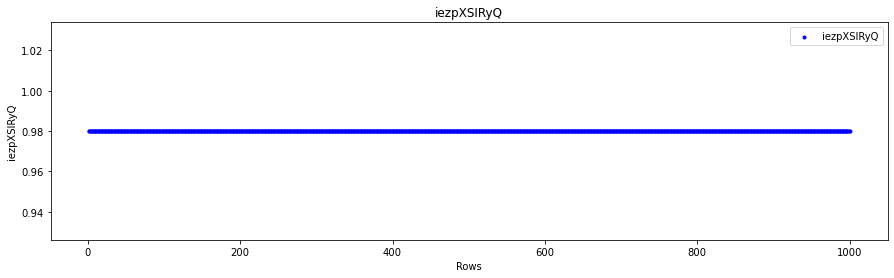

Column =  BmpcKiosIw
1       0.71
2       3.76
3       4.17
4       4.44
5       4.66
        ... 
1058    4.92
1059    7.14
1060    7.17
1061    7.18
1062    7.18
Name: BmpcKiosIw, Length: 1000, dtype: float64


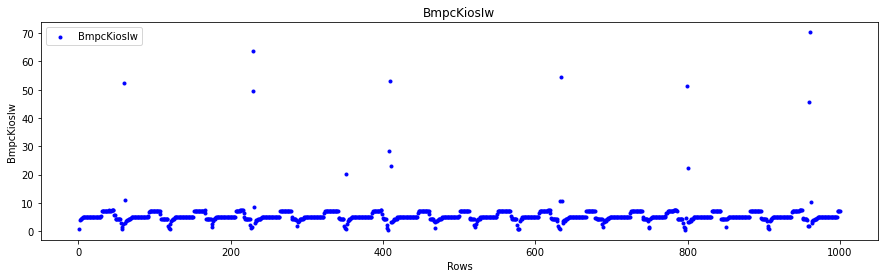

Column =  XnKsCBLOqH
1       306.0
2       308.0
3       307.0
4       307.0
5       307.0
        ...  
1058    372.0
1059    369.0
1060    368.0
1061    367.0
1062    366.0
Name: XnKsCBLOqH, Length: 1000, dtype: float64


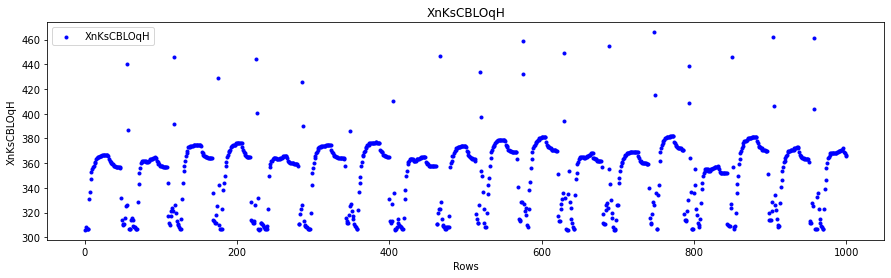

Column =  GEErHMkWtLOrD
1       119.0
2       119.0
3       120.0
4       119.0
5       119.0
        ...  
1058    120.0
1059    121.0
1060    121.0
1061    121.0
1062    121.0
Name: GEErHMkWtLOrD, Length: 1000, dtype: float64


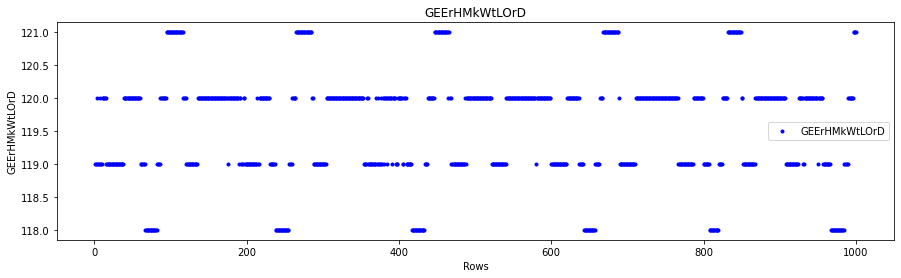

Column =  ATisLDMDDfZrI
1       129.0
2       128.0
3       128.0
4       127.0
5       127.0
        ...  
1058    128.0
1059    129.0
1060    129.0
1061    129.0
1062    129.0
Name: ATisLDMDDfZrI, Length: 1000, dtype: float64


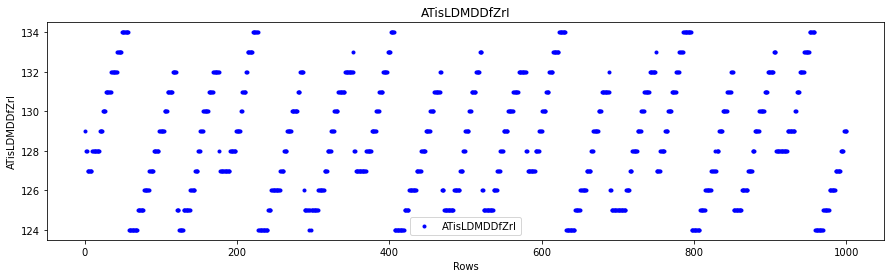

Column =  ZhitvZfLGQzyC
1       145.0
2       144.0
3       144.0
4       144.0
5       145.0
        ...  
1058    139.0
1059    141.0
1060    142.0
1061    142.0
1062    142.0
Name: ZhitvZfLGQzyC, Length: 1000, dtype: float64


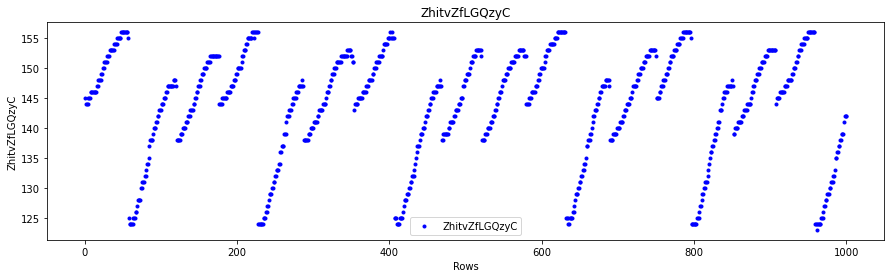

Column =  SwpYipezsdueC
1       125.0
2       123.0
3       123.0
4       123.0
5       123.0
        ...  
1058    135.0
1059    137.0
1060    137.0
1061    137.0
1062    137.0
Name: SwpYipezsdueC, Length: 1000, dtype: float64


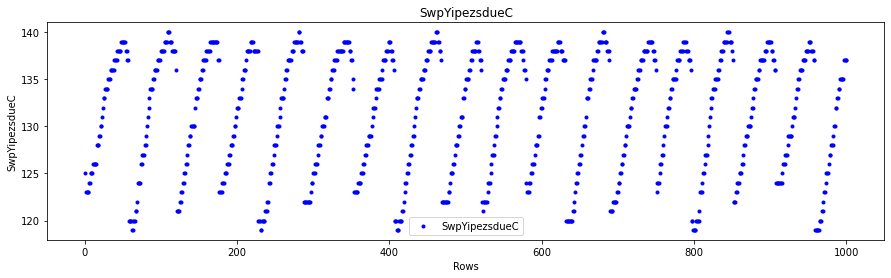

Column =  YiAwOaAhwskZcEfg
1        3.0
2      -72.0
3      -72.0
4      -72.0
5      -72.0
        ... 
1058   -76.0
1059   -76.0
1060   -76.0
1061   -76.0
1062   -76.0
Name: YiAwOaAhwskZcEfg, Length: 1000, dtype: float64


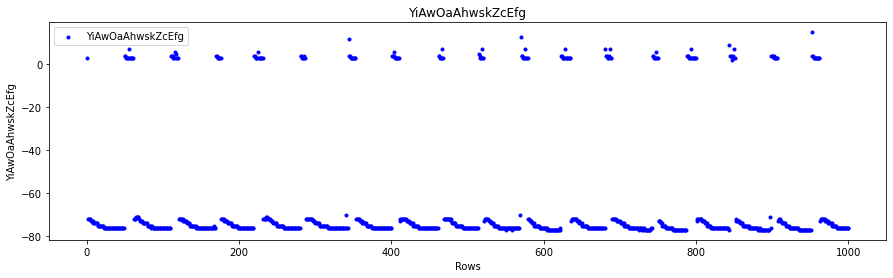

Column =  CxPgKZCqQsFtMQZdEkFTQ
1       3.0
2       3.0
3       3.0
4       3.0
5       3.0
       ... 
1058    3.0
1059    3.0
1060    3.0
1061    3.0
1062    3.0
Name: CxPgKZCqQsFtMQZdEkFTQ, Length: 1000, dtype: float64


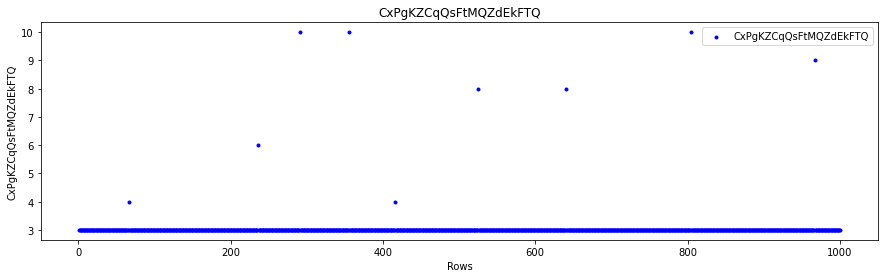

Column =  EcBnlzqiTwFxSSBTvYsYOOaCax
1       0.0
2       0.0
3       0.2
4       1.8
5       0.7
       ... 
1058    0.9
1059    0.9
1060    0.9
1061    1.0
1062    0.9
Name: EcBnlzqiTwFxSSBTvYsYOOaCax, Length: 1000, dtype: float64


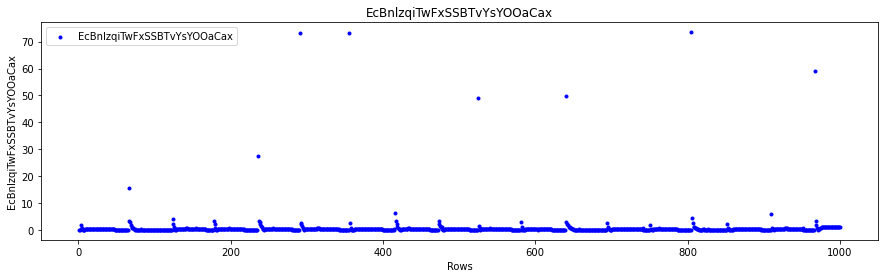

Column =  UYmpqidlVJQGSXnENDNUVUTbp
1       7.00
2       7.00
3       6.83
4       7.00
5       7.00
        ... 
1058    7.00
1059    7.00
1060    7.00
1061    7.00
1062    7.00
Name: UYmpqidlVJQGSXnENDNUVUTbp, Length: 1000, dtype: float64


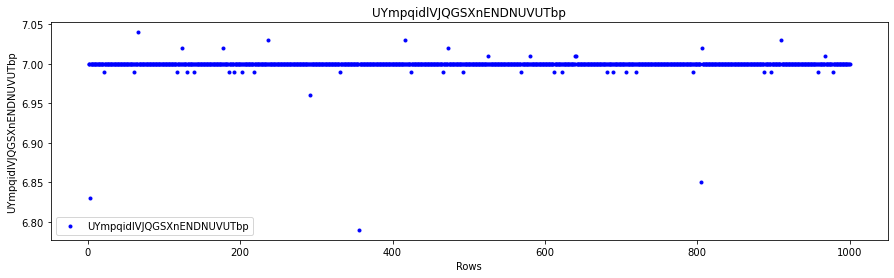

Column =  QveHzspDQenotLMRwWdjK
1       5.85
2       5.84
3       5.85
4       6.45
5       6.33
        ... 
1058    6.25
1059    6.25
1060    6.24
1061    6.25
1062    6.25
Name: QveHzspDQenotLMRwWdjK, Length: 1000, dtype: float64


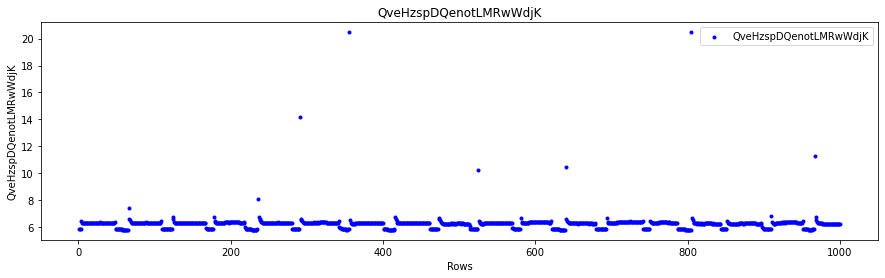

Column =  tzEiBNrESroInUjAStFCzgiCYU
1       0.00
2       0.00
3       0.01
4       0.61
5       0.49
        ... 
1058    0.37
1059    0.37
1060    0.36
1061    0.37
1062    0.37
Name: tzEiBNrESroInUjAStFCzgiCYU, Length: 1000, dtype: float64


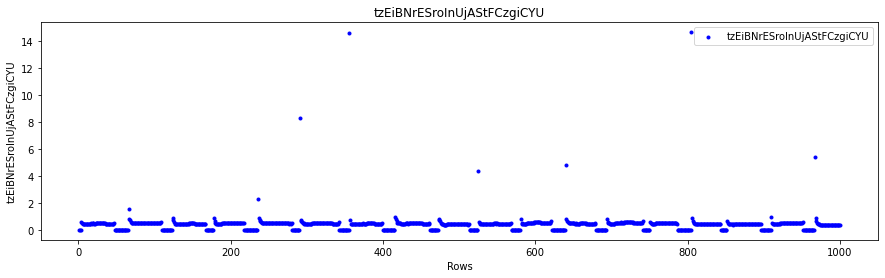

Column =  OeFBBIdvVlvVTeDufgEbQZtuB
1       9.49
2       9.49
3       9.63
4       9.49
5       9.49
        ... 
1058    9.49
1059    9.49
1060    9.49
1061    9.49
1062    9.49
Name: OeFBBIdvVlvVTeDufgEbQZtuB, Length: 1000, dtype: float64


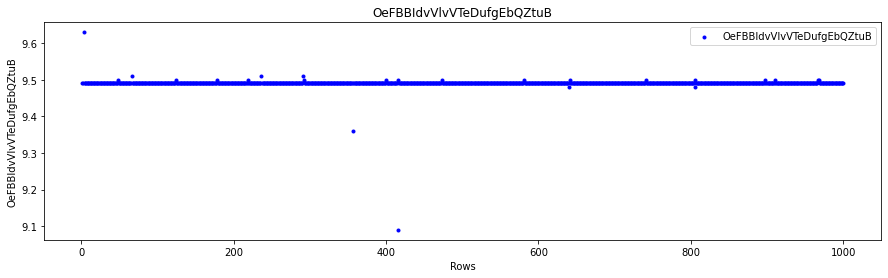

Column =  TyPUktVeQlH
1        13.0
2       968.0
3       968.0
4       968.0
5       968.0
        ...  
1058    968.0
1059    968.0
1060    968.0
1061    968.0
1062    968.0
Name: TyPUktVeQlH, Length: 1000, dtype: float64


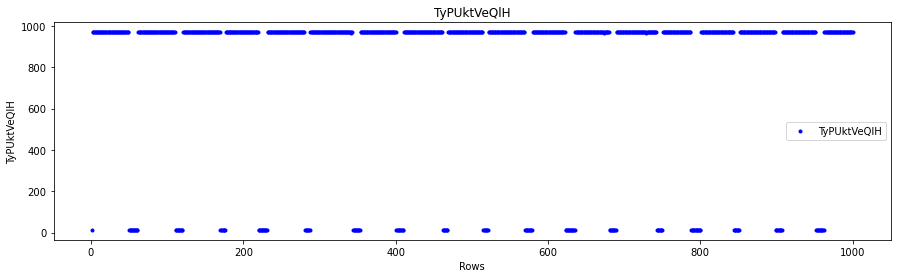

Column =  ArsbiQzICA
1        99.0
2       111.0
3       111.0
4       111.0
5       111.0
        ...  
1058    111.0
1059    111.0
1060    111.0
1061    111.0
1062    111.0
Name: ArsbiQzICA, Length: 1000, dtype: float64


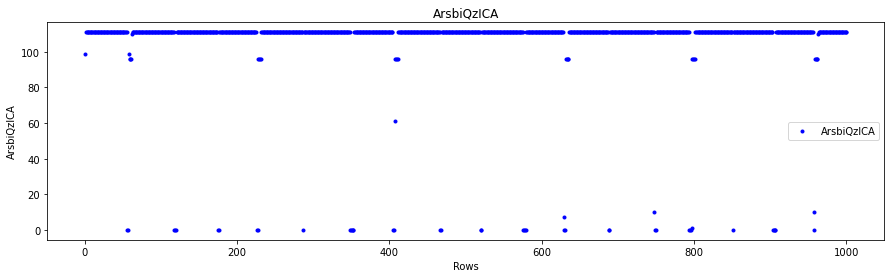

Column =  ueAWtcWKJJ
1        6.46
2       16.03
3       16.06
4       16.06
5       16.06
        ...  
1058    16.10
1059    16.06
1060    16.03
1061    16.06
1062    16.06
Name: ueAWtcWKJJ, Length: 1000, dtype: float64


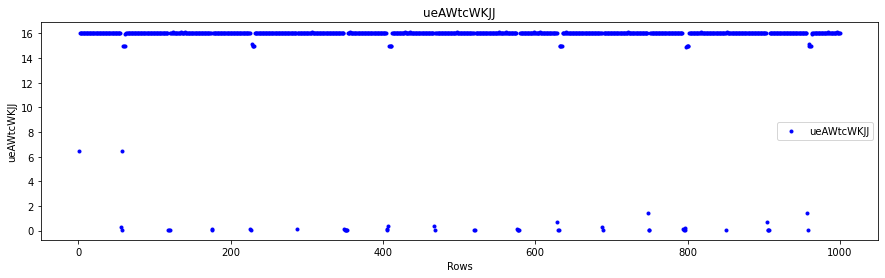

Column =  WLGtKKqZiN
1         0.0
2       127.0
3       127.0
4        86.0
5       106.0
        ...  
1058    106.0
1059    179.0
1060    179.0
1061    179.0
1062    179.0
Name: WLGtKKqZiN, Length: 1000, dtype: float64


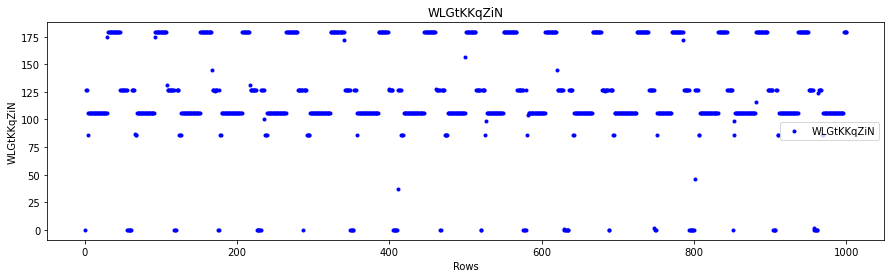

Column =  YffEHvEJjM
1        0.0
2        0.0
3       35.0
4       40.0
5       49.0
        ... 
1058    49.0
1059    86.0
1060    86.0
1061    86.0
1062    86.0
Name: YffEHvEJjM, Length: 1000, dtype: float64


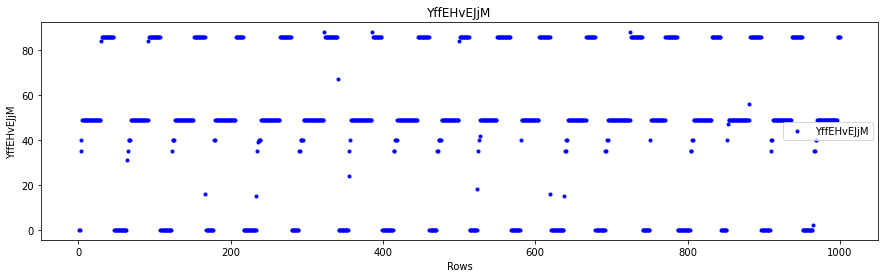

Column =  TNfKYBQBdc
1        0.00
2        0.00
3        4.04
4        7.05
5        9.15
        ...  
1058     9.14
1059    13.46
1060    13.46
1061    13.46
1062    13.46
Name: TNfKYBQBdc, Length: 1000, dtype: float64


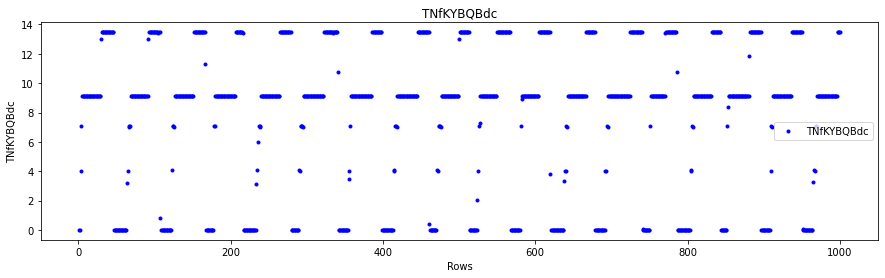

Column =  ETYSQPkJNbQsmWtwf
1        98.0
2       200.0
3       206.0
4       199.0
5       201.0
        ...  
1058    201.0
1059    223.0
1060    224.0
1061    224.0
1062    224.0
Name: ETYSQPkJNbQsmWtwf, Length: 1000, dtype: float64


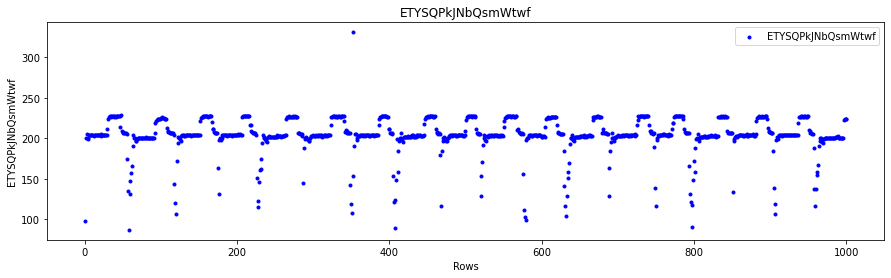

Column =  dCEQyYYpj
1       2.47
2       2.47
3       2.47
4       2.47
5       2.47
        ... 
1058    2.47
1059    2.47
1060    2.47
1061    2.47
1062    2.47
Name: dCEQyYYpj, Length: 1000, dtype: float64


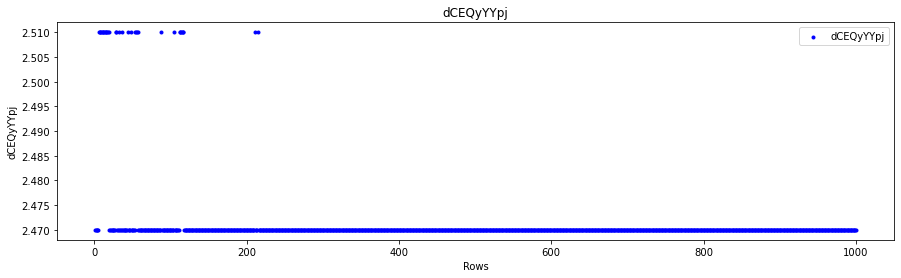

Column =  taQyPEGv
1       0.738
2       0.738
3       0.738
4       0.738
5       0.738
        ...  
1058    0.738
1059    0.738
1060    0.738
1061    0.738
1062    0.738
Name: taQyPEGv, Length: 1000, dtype: float64


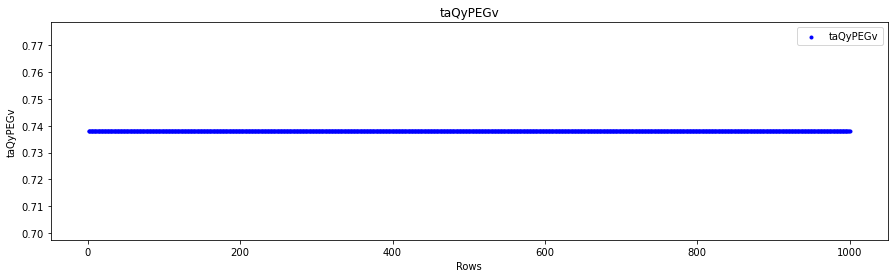

Column =  dSqlDZohVx
1       4852.0
2       4852.0
3       4852.0
4       4852.0
5       4852.0
         ...  
1058    4877.0
1059    4877.0
1060    4877.0
1061    4877.0
1062    4877.0
Name: dSqlDZohVx, Length: 1000, dtype: float64


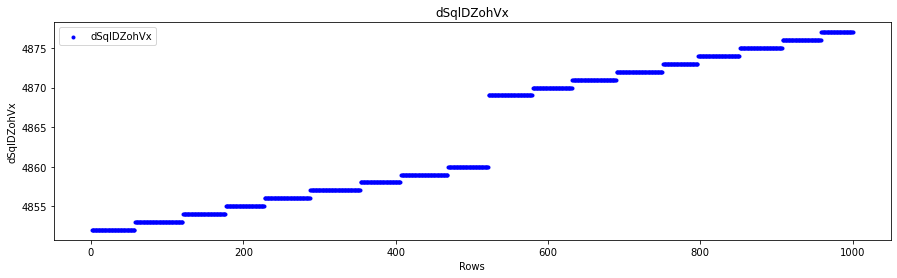

Column =  pIzvhgujbH
1          1.0
2          1.0
3          1.0
4       1251.0
5       2651.0
         ...  
1058    2802.0
1059    2802.0
1060    2802.0
1061    2801.0
1062    2802.0
Name: pIzvhgujbH, Length: 1000, dtype: float64


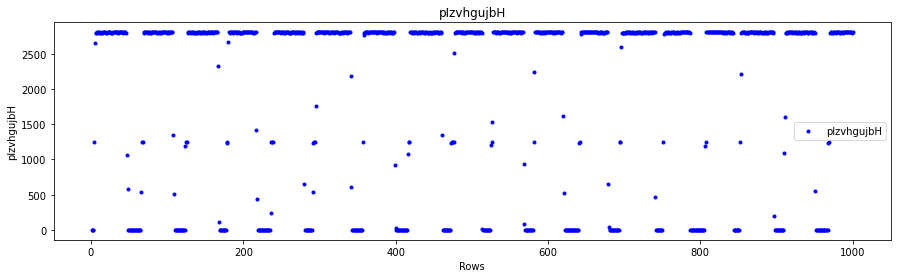

Column =  XAsiHMsvPv
1        0.0
2        0.0
3        0.0
4        0.0
5       63.0
        ... 
1058     2.0
1059     2.0
1060     1.0
1061     2.0
1062     2.0
Name: XAsiHMsvPv, Length: 1000, dtype: float64


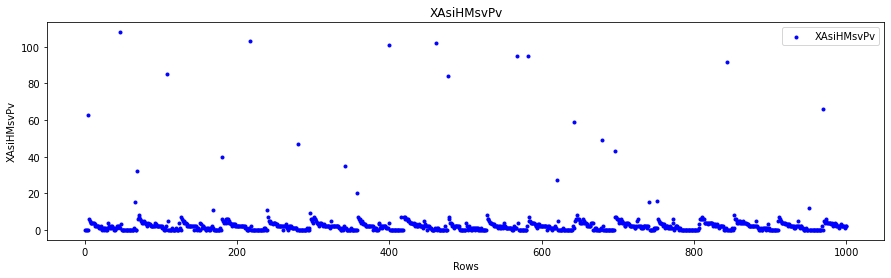

Column =  RUNSjtpEAy
1        0.0
2       12.0
3        8.0
4        6.0
5        4.0
        ... 
1058     6.0
1059     5.0
1060     4.0
1061     4.0
1062     4.0
Name: RUNSjtpEAy, Length: 1000, dtype: float64


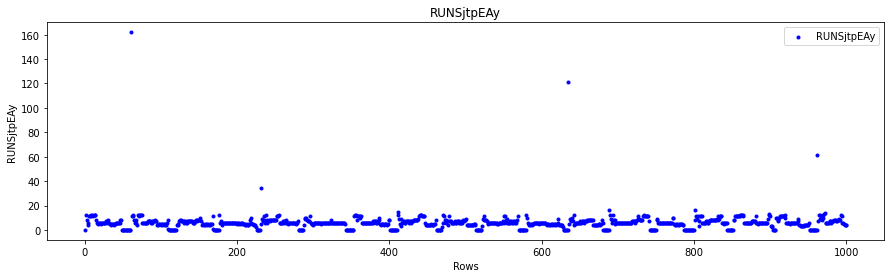

Column =  YATWcaRqpB
1       0.0
2       5.0
3       4.0
4       3.0
5       2.0
       ... 
1058    3.0
1059    2.0
1060    2.0
1061    2.0
1062    2.0
Name: YATWcaRqpB, Length: 1000, dtype: float64


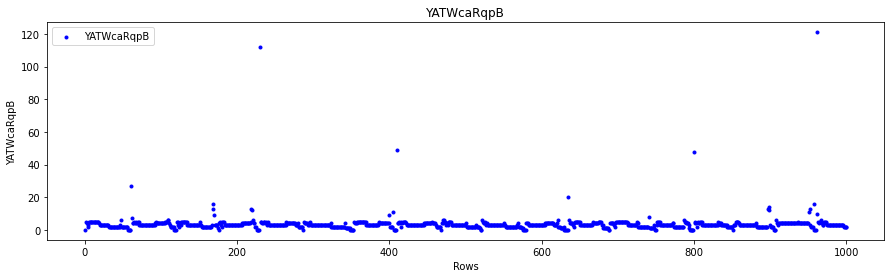

Column =  nJdvUmCcjI
1          0.0
2       1304.0
3       1305.0
4       1302.0
5       1302.0
         ...  
1058    1305.0
1059    1302.0
1060    1302.0
1061    1302.0
1062    1304.0
Name: nJdvUmCcjI, Length: 1000, dtype: float64


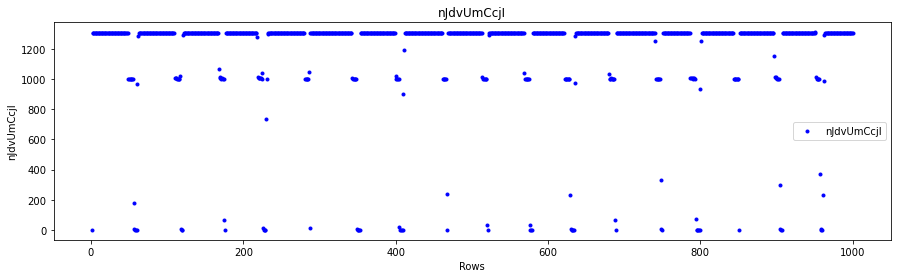

Column =  NACdQXDDBP
1          0.0
2       3110.0
3       3107.0
4       3104.0
5       3103.0
         ...  
1058    3104.0
1059    3103.0
1060    3104.0
1061    3103.0
1062    3104.0
Name: NACdQXDDBP, Length: 1000, dtype: float64


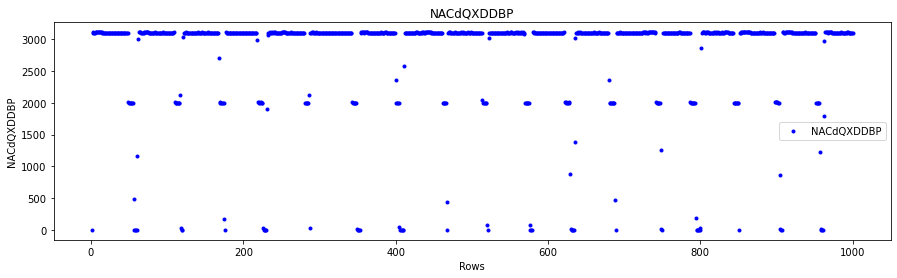

Column =  NyUITkJtCGK
1       0.74
2       0.74
3       0.74
4       0.74
5       0.74
        ... 
1058    0.74
1059    0.74
1060    0.74
1061    0.74
1062    0.74
Name: NyUITkJtCGK, Length: 1000, dtype: float64


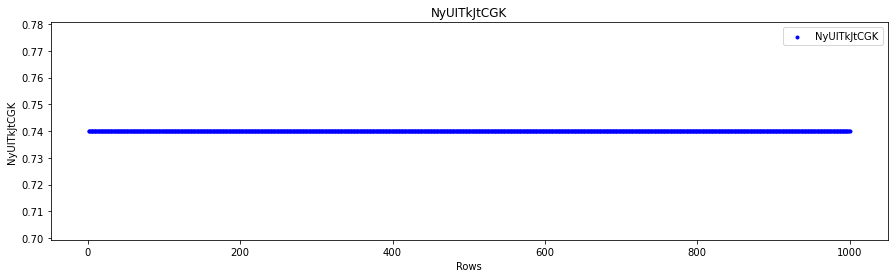

Column =  QesumGN
1        2.0
2        7.0
3        8.0
4        9.0
5       11.0
        ... 
1058    11.0
1059    15.0
1060    15.0
1061    15.0
1062    15.0
Name: QesumGN, Length: 1000, dtype: float64


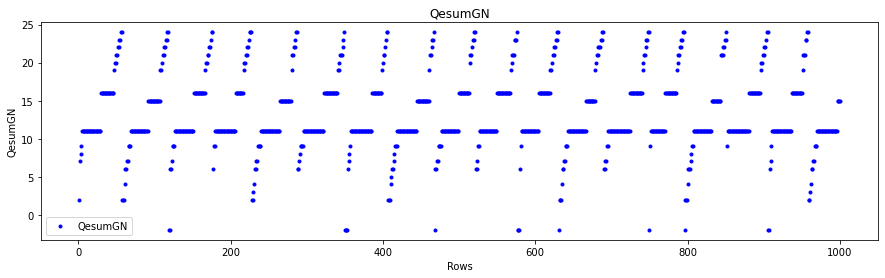

Column =  ETcatZBXS
1         500.0
2         300.0
3         300.0
4        6200.0
5        1400.0
         ...   
1058    84000.0
1059     9400.0
1060    13500.0
1061    15700.0
1062    17900.0
Name: ETcatZBXS, Length: 1000, dtype: float64


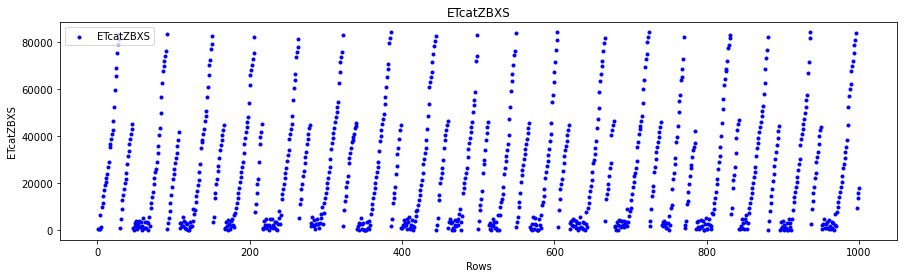

Column =  RnVvcKsHhDEyb
1       81.0
2       81.0
3       81.0
4       81.0
5       81.0
        ... 
1058    83.0
1059    83.0
1060    83.0
1061    83.0
1062    83.0
Name: RnVvcKsHhDEyb, Length: 1000, dtype: float64


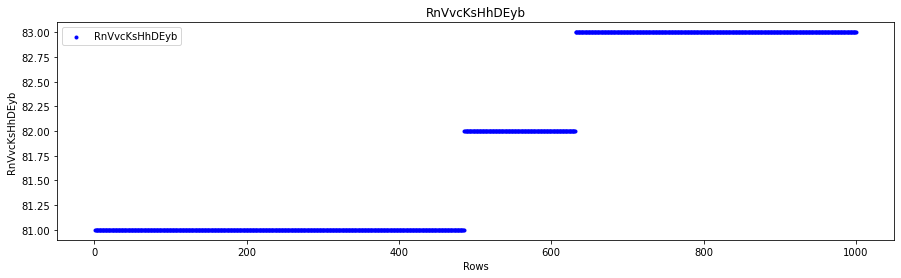

Column =  tMqophNywoUtXsGZAeVHBvtFjuyM
1        -25.0
2       1890.0
3       1890.0
4       1890.0
5       1890.0
         ...  
1058    1890.0
1059    1890.0
1060    1890.0
1061    1890.0
1062    1890.0
Name: tMqophNywoUtXsGZAeVHBvtFjuyM, Length: 1000, dtype: float64


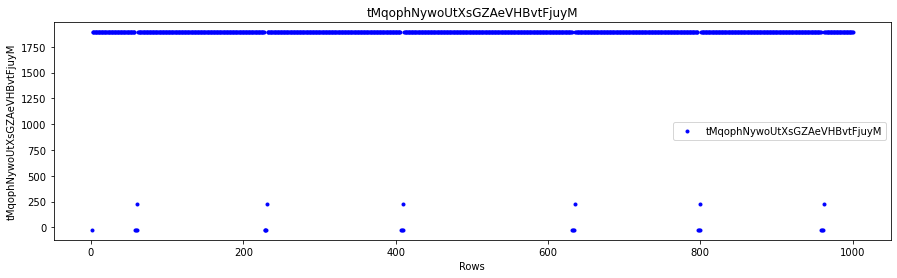

Column =  CalcStepSeq
1       1.0
2       2.0
3       3.0
4       4.0
5       5.0
       ... 
1058    7.0
1059    8.0
1060    8.0
1061    8.0
1062    8.0
Name: CalcStepSeq, Length: 1000, dtype: float64


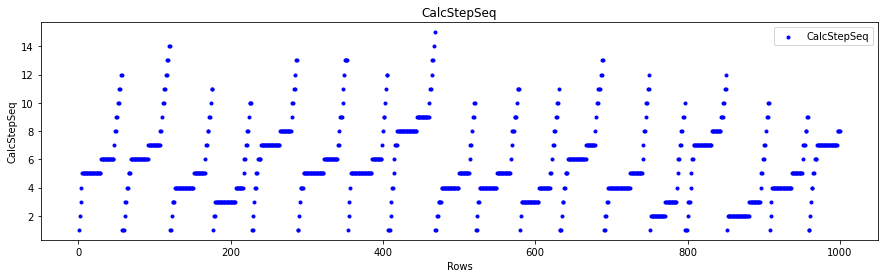

Column =  CalcLoopSeq
1       1.0
2       2.0
3       3.0
4       4.0
5       5.0
       ... 
1058    7.0
1059    8.0
1060    8.0
1061    8.0
1062    8.0
Name: CalcLoopSeq, Length: 1000, dtype: float64


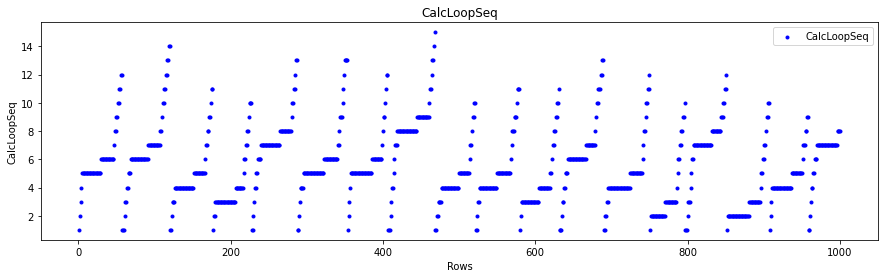

In [24]:
# Plot all column into chart to visualise the data, print out some content of data to inspect
# Jupyter -> Cell -> Current Output -> Toggle Scrolling (to enable/disable scrolling)
# Zoom into first 1000 rows out of 13000 rows
df1=df.iloc[:1000]
for column in df1.columns:
    print('Column = ', column)
    print(df1[column])
    
    # Generate x-coordinates as a sequence of numbers
    x_data = list(range(1, len(df1[column]) + 1))

    # Create a scatter plot
    plt.figure(figsize=(15, 4))
    plt.scatter(x_data, df1[column], marker='.', color='blue', label=column)

    # Add labels and a title
    plt.xlabel('Rows')
    plt.ylabel(column)
    plt.title(column)

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

<h4>Conclusion: Based on the time series data visualisation, there is not much feature engineering that can be done unless there is a strong domain knowledge of the sensor data and correlation of the sensor data. Other feature engineer approaches, such as scaling and resampling, will be used during model training.

<h2>3. Feature Selection

<h2>3.1 Pick up patterns from previous visualisation and investigate further

* Here are the columns that look like there are some patterns here:
  * OunhHslCRwIRilo
  * BmpcKiosIw
  * XnKsCBLOqH
  * SwpYipezsdueC
  * XAsiHMsvPv
  * RUNSjtpEAy
  * YATWcaRqpB
  * QesumGN
  * ETcatZBXS
  * ZhitvZfLGQzyC
  * pIzvhgujbH
  * CalcStepSeq
  * CalcLoopSeq
  * GEErHMkWtLOrD
* Some of the columns need to remove the noise or outliers and then redraw to have a better picture:
  * EcBnlzqiTwFxSSBTvYsYOOaCax
  * QveHzspDQenotLMRwWdjK
  * tzEiBNrESroInUjAStFCzgiCYU
  * YffEHvEJjM
  * ETYSQPkJNbQsmWtwf
* Strange patterns in the initial data: dCEQyYYpj
* Broken Run numbers to zoom into detail

<h3>3.1.1 Analyse Run Column</h3>
Based on the TimeStamp, each run (run-time) generates a new set of sensor data output, and it seems to be the most important column to study and utilize for further data analysis. We will study and zoom into the “break-point” or none-continuous number of the Run numbers and the number of rows generated for each run.

<h4>3.1.1.1 Zoom into Run column's Breakpoints

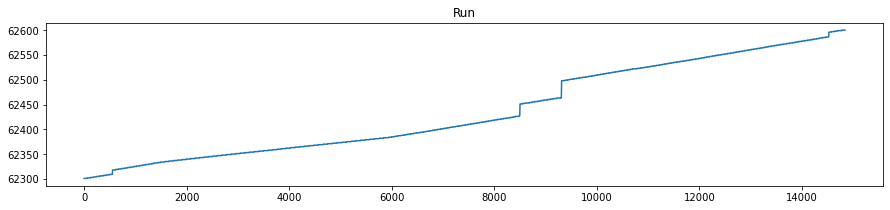

In [25]:
# Re-plot Run column
run_column = df['Run']
plt.figure(figsize=(15, 3))
plt.title('Run') 
plt.plot(run_column)
plt.show()

540    62309
541    62309
542    62309
543    62309
544    62309
545    62309
546    62309
547    62309
549    62309
550    62309
551    62309
554    62318
555    62318
556    62318
557    62318
558    62318
559    62318
560    62318
Name: Run, dtype: int64


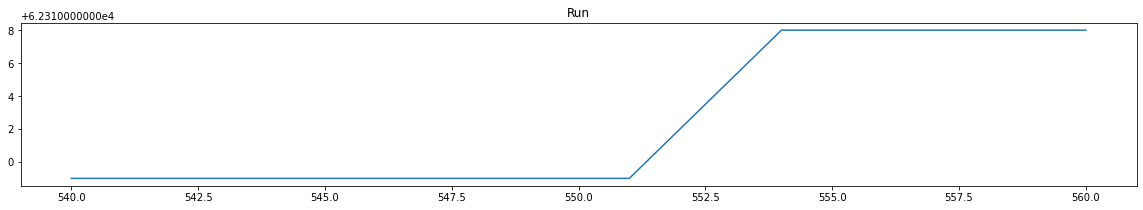

In [26]:
# Zoom to row 500, 8000-10000, 14000+
run_column = df.loc[540:560, 'Run']
print(run_column)
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.plot(run_column)

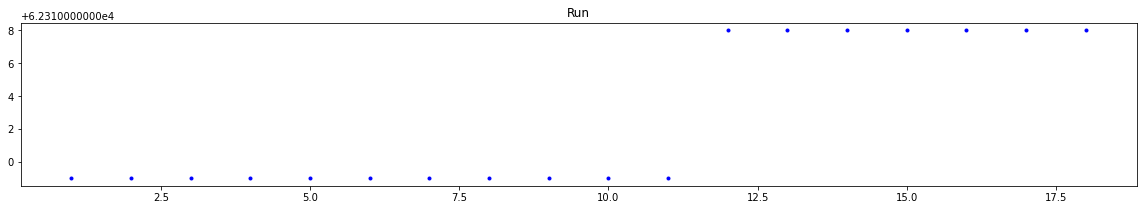

In [27]:
# Do scatter plot to counter verify
run_column = df.loc[540:560, 'Run']
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.scatter(x_data, run_column, marker='.', color='blue', label=column)

Conclusion: Seems like there is no problem with the first break-point

8000     62418
8001     62418
8004     62419
8005     62419
8006     62419
         ...  
9996     62509
9997     62509
9998     62509
9999     62509
10000    62509
Name: Run, Length: 1799, dtype: int64


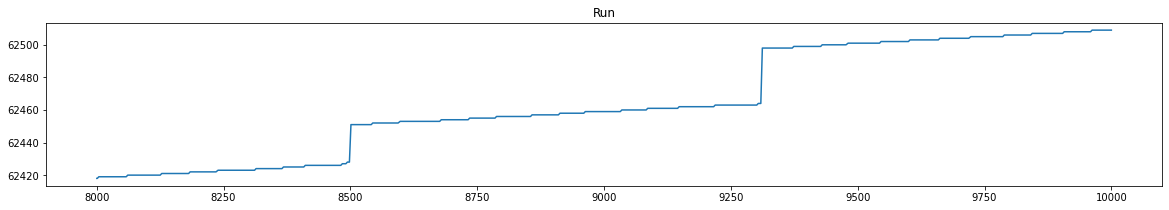

In [28]:
# Zoom to row 8000-10000, 14000+
run_column = df.loc[8000:10000, 'Run']
print(run_column)
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.plot(run_column)

8470    62426
8471    62426
8472    62426
8473    62426
8474    62426
        ...  
8593    62452
8594    62452
8598    62453
8599    62453
8600    62453
Name: Run, Length: 101, dtype: int64


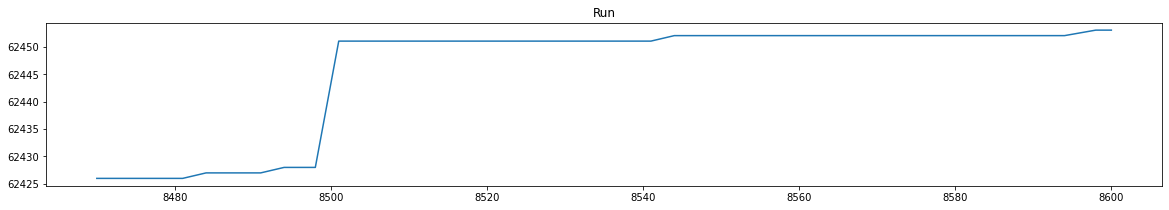

In [29]:
# Zoom to row 8000-10000, 14000+
run_column = df.loc[8470:8600, 'Run']
print(run_column)
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.plot(run_column)

<h4>Finding 1: Found strange pattern around 8470 - 8500, around Run number 62426++

9250    62463
9251    62463
9252    62463
9253    62463
9254    62463
        ...  
9346    62498
9347    62498
9348    62498
9349    62498
9350    62498
Name: Run, Length: 95, dtype: int64


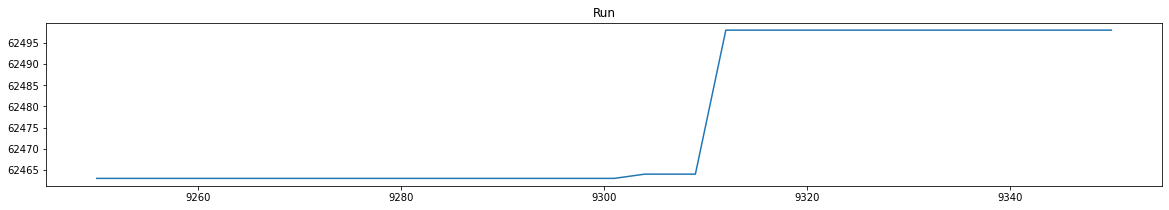

In [30]:
# Zoom to row 8000-10000, 14000+
run_column = df.loc[9250:9350, 'Run']
print(run_column)
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.plot(run_column)

<h4>Finding 2: Found strange pattern around 9300-9310, Run number 62463+

14000    62578
14002    62578
14004    62578
14005    62578
14007    62578
         ...  
14838    62600
14839    62600
14840    62600
14841    62600
14842    62600
Name: Run, Length: 797, dtype: int64


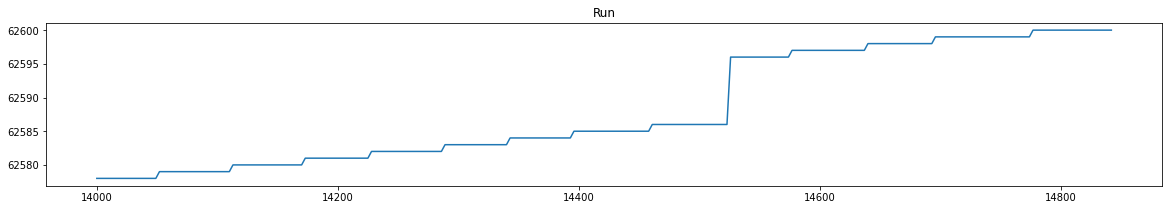

In [31]:
# Zoom to row 500, 8000-10000, 14000+
run_column = df.loc[14000:, 'Run']
print(run_column)
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.plot(run_column)

14500    62586
14501    62586
14502    62586
14503    62586
14504    62586
14505    62586
14506    62586
14507    62586
14508    62586
14509    62586
14510    62586
14511    62586
14512    62586
14514    62586
14515    62586
14516    62586
14517    62586
14518    62586
14519    62586
14520    62586
14521    62586
14522    62586
14523    62586
14526    62596
14527    62596
14528    62596
14529    62596
14530    62596
Name: Run, dtype: int64


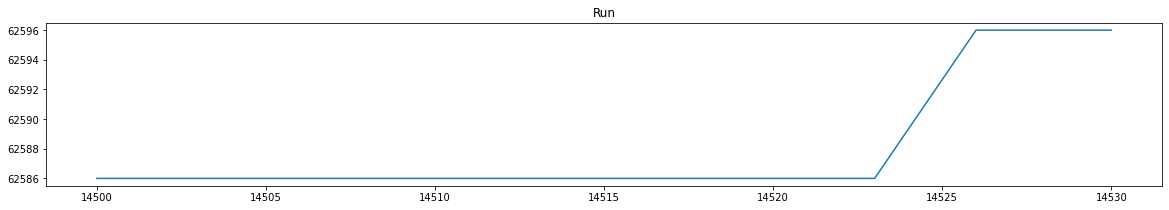

In [32]:
# Zoom to row 14000+
run_column = df.loc[14500:14530, 'Run']
print(run_column)
x_data = list(range(1, len(run_column) + 1))
plt.figure(figsize=(20, 3))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Run') 
plt.plot(run_column)

Conclusion: The pattern looks fine here.

<h4>3.1.1.2 Study the Run's row numbers

In [33]:
# Get unique run numbers 
runs = df['Run'].unique()
print('Total Unique Runs=',len(runs))
#runs

df_run = pd.DataFrame()
i=0
# Calculate each Run's lenght and record inside df_run
for run in runs:
    count = (df['Run'] == run).sum()
    df_run.loc[i, 'Run'] = run
    df_run.loc[i, 'Count'] = count
    i=i+1
df_run.head()

Total Unique Runs= 228


Run  Count
0  62301.0   57.0
1  62302.0   63.0
2  62303.0   56.0
3  62304.0   51.0
4  62305.0   60.0

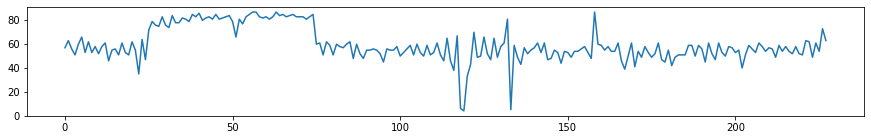

Run       Count
count    228.000000  228.000000
mean   62446.407895   59.899123
std       91.029430   14.338372
min    62301.000000    4.000000
25%    62365.750000   51.750000
50%    62422.500000   57.000000
75%    62534.250000   65.250000
max    62600.000000   87.000000

In [34]:
# Visualize the number of rows for each Run
df_run['Count'].plot(figsize=(15, 2))
plt.show() 
df_run.describe()

In [35]:
# The chart shows that there are few points that is very near to zero (min count = 4)
# Filter rows with values below half of the mean, those very few counts can be consider Abnormal
percentile_25 = df_run.mean()/2
print(percentile_25)
rows_below_mean = df_run[(df_run['Count'] < percentile_25['Count']) ]
rows_below_mean

Run      31223.203947
Count       29.949561
dtype: float64


Run  Count
118  62427.0    6.0
119  62428.0    4.0
133  62464.0    5.0

<h4>Finding 3: Run number 62427, 62428, and 62464 has only less than seven rows or less than seven sensor data. This could mean the sensor tool is faulty as no data is coming from the sensor tool. 

<h3>3.1.2 Analyse Columns with Patterns we found previously</h3>

* Seems like there are some patterns here:
  * OunhHslCRwIRilo
  * BmpcKiosIw
  * XnKsCBLOqH
  * SwpYipezsdueC
  * XAsiHMsvPv
  * RUNSjtpEAy
  * YATWcaRqpB
  * QesumGN
  * ETcatZBXS
  * ZhitvZfLGQzyC
  * pIzvhgujbH
  * CalcStepSeq
  * CalcLoopSeq
  * GEErHMkWtLOrD

<h4>3.1.2.1 Start with analysing the first OunhHslCRwIRilo column

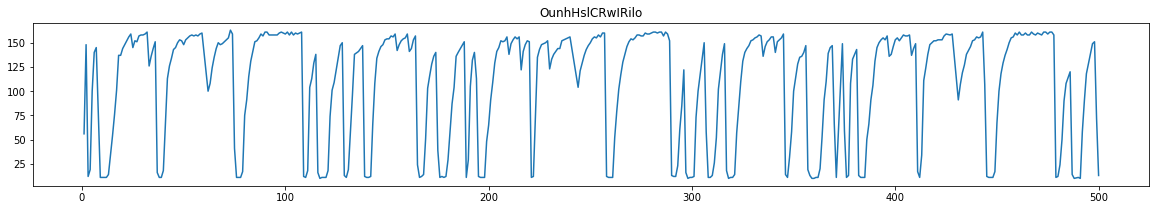

In [36]:
# Zoom to first few hunderd rows
mycolumn = 'OunhHslCRwIRilo'
selected_column = df.loc[:500, mycolumn]
x_data = list(range(1, len(selected_column) + 1))
plt.figure(figsize=(20, 3))
plt.title(mycolumn) 
plt.plot(selected_column)

The patterns in OunhHslCRwIRilo looks quite random. Try zoome into per Run pattern

In [37]:
# Remove all columns except OunhHslCRwIRilo and Run column
mycolumn = 'OunhHslCRwIRilo'
df_column=df
for column in df.columns:
    if column != mycolumn and column != 'Run':
        df_column=df_column.drop(column, axis=1)

# Split data into dicts by run number
data_by_run = {run: df_column[df_column['Run'] == run] for run in runs}

print(df_column.shape)
df_column.head()

(13657, 2)


Run  OunhHslCRwIRilo
1  62301             56.0
2  62301            148.0
3  62301             12.0
4  62301             19.0
5  62301            100.0

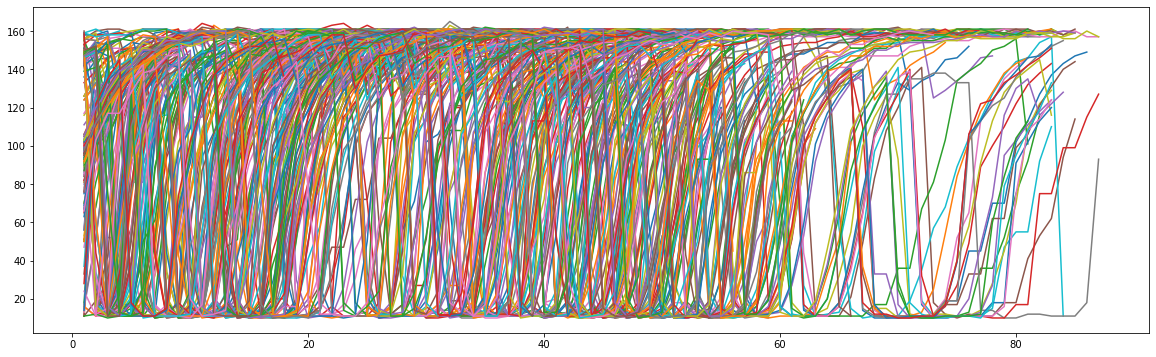

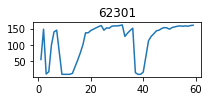

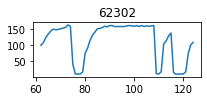

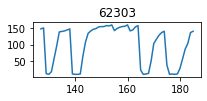

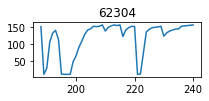

In [38]:
# Plot all the Runs with its pattern into single chart, and also into a few different chart
#import matplotlib.pyplot as plt2 
i=0
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

for run, df1 in data_by_run.items():
    #print(f"Run {run}")
    i = i + 1
    # Exam the first new charts only, the plot all
    #if i > 20:
    #    break
    y_data = df1[mycolumn]
    x_data = list(range(1, len(y_data) + 1))
    # Plot the first line
    ax.plot(x_data, y_data, label=run)

    # Print the first few chart individually
    if i < 5:
        # Create another figure
        fig2, ax2 = plt.subplots(figsize=(3, 1))
        ax2.set_title(run) 
        ax2.plot(y_data)
plt.show()

The fully combined chart is messy and not that straightforward, but those single charts may be usable. Let us explore other potential columns/features.

BmpcKiosIw
     Run  BmpcKiosIw
1  62301        0.71
2  62301        3.76
3  62301        4.17
4  62301        4.44
5  62301        4.66


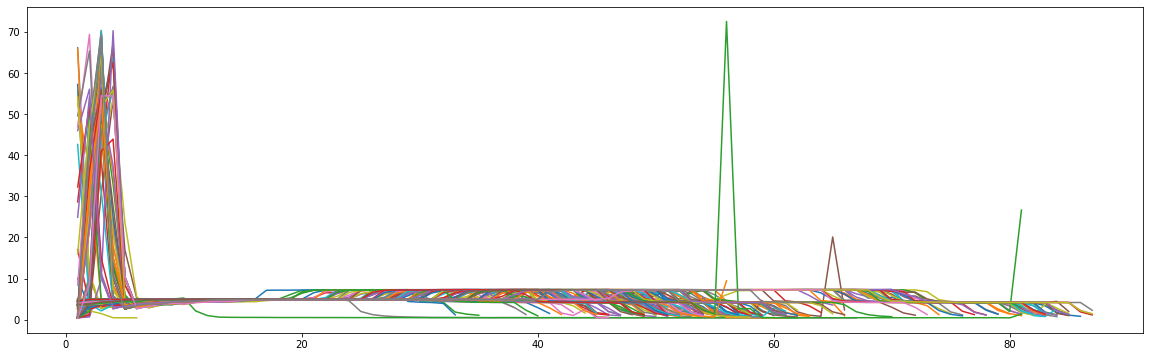

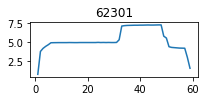

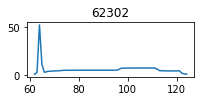

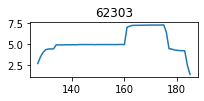

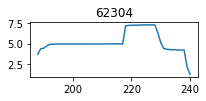

XnKsCBLOqH
     Run  XnKsCBLOqH
1  62301       306.0
2  62301       308.0
3  62301       307.0
4  62301       307.0
5  62301       307.0


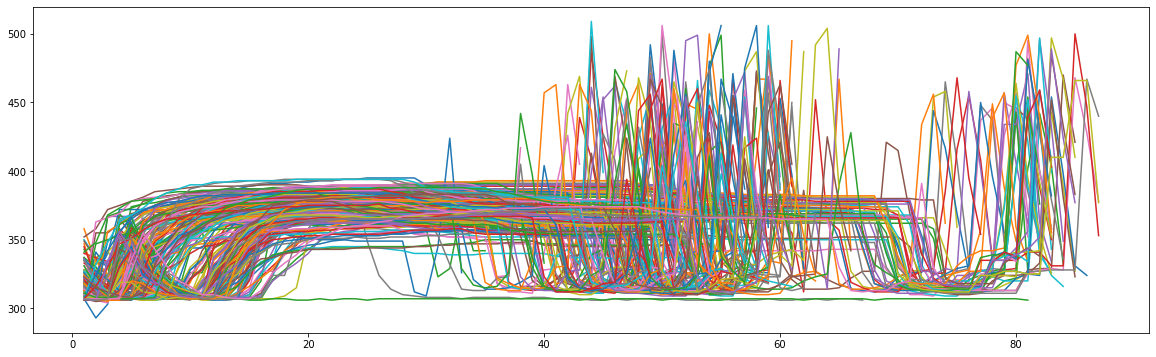

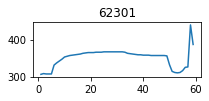

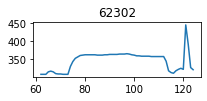

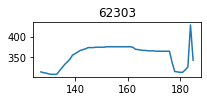

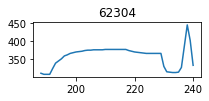

SwpYipezsdueC
     Run  SwpYipezsdueC
1  62301          125.0
2  62301          123.0
3  62301          123.0
4  62301          123.0
5  62301          123.0


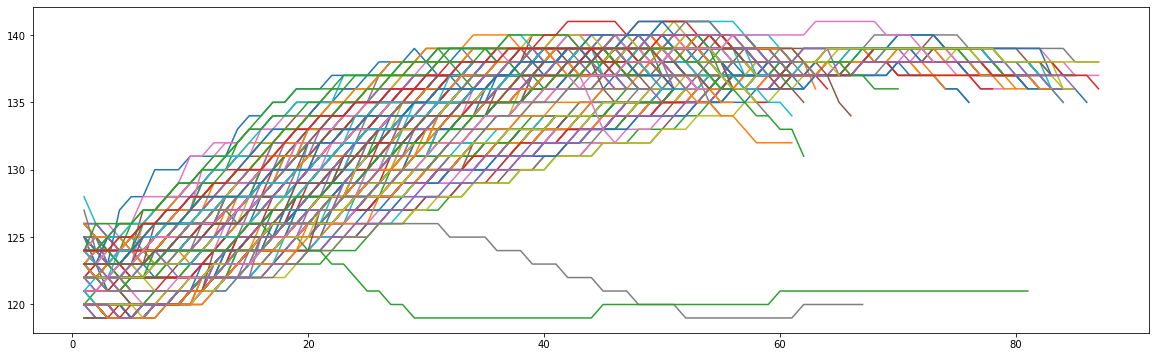

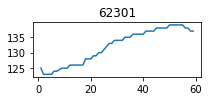

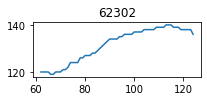

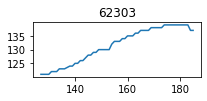

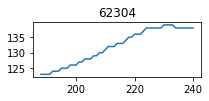

XAsiHMsvPv
     Run  XAsiHMsvPv
1  62301         0.0
2  62301         0.0
3  62301         0.0
4  62301         0.0
5  62301        63.0


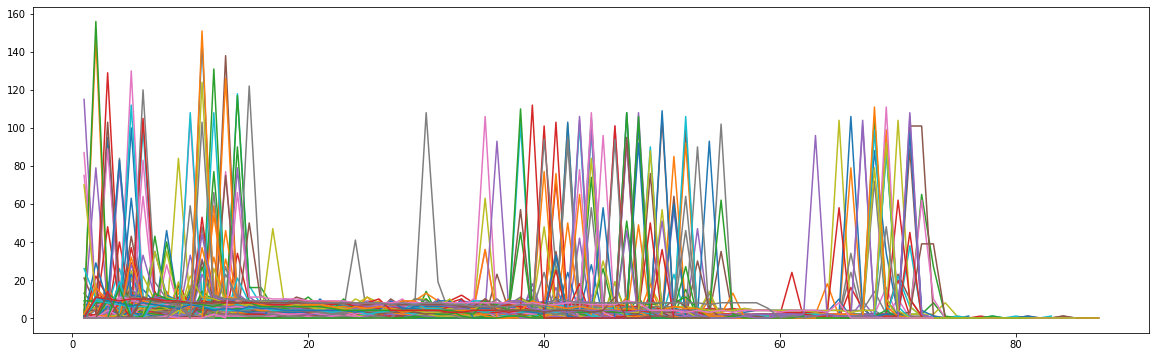

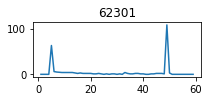

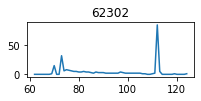

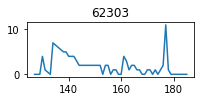

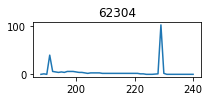

RUNSjtpEAy
     Run  RUNSjtpEAy
1  62301         0.0
2  62301        12.0
3  62301         8.0
4  62301         6.0
5  62301         4.0


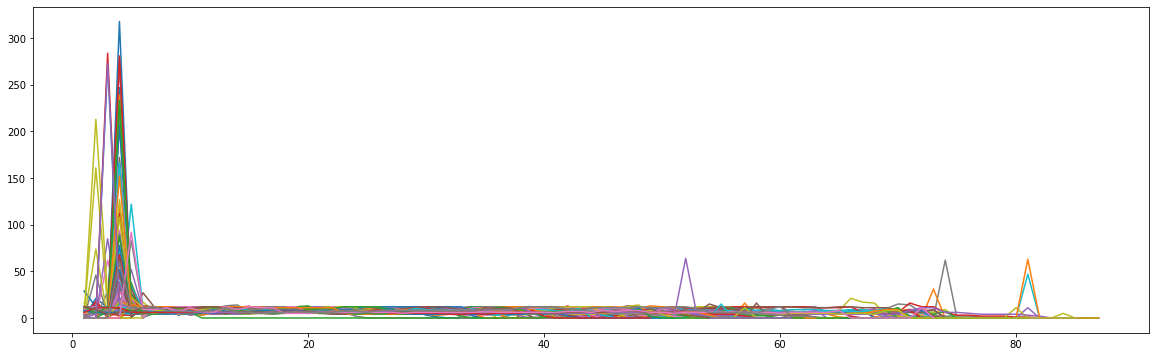

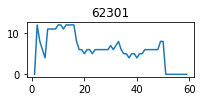

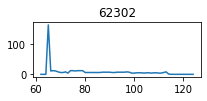

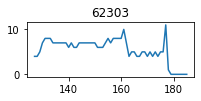

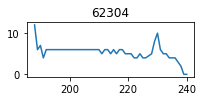

YATWcaRqpB
     Run  YATWcaRqpB
1  62301         0.0
2  62301         5.0
3  62301         4.0
4  62301         3.0
5  62301         2.0


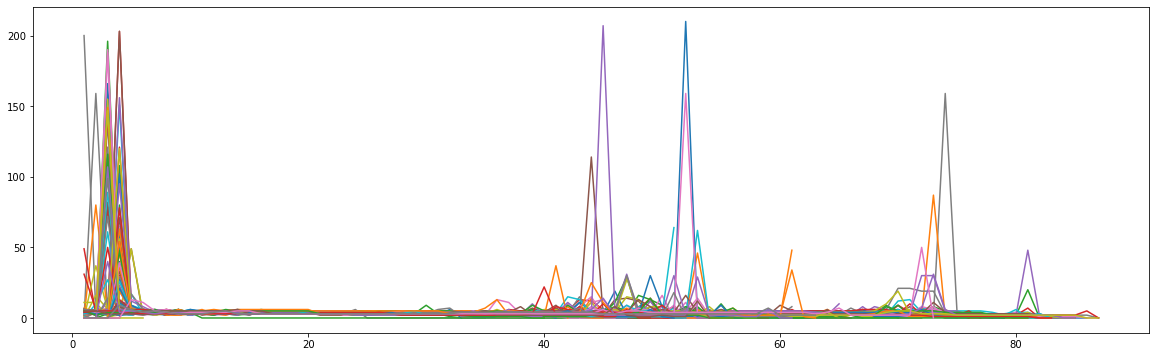

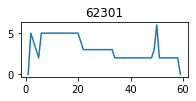

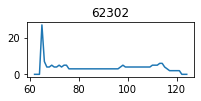

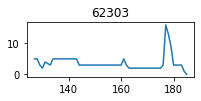

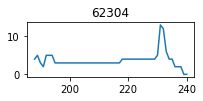

QesumGN
     Run  QesumGN
1  62301      2.0
2  62301      7.0
3  62301      8.0
4  62301      9.0
5  62301     11.0


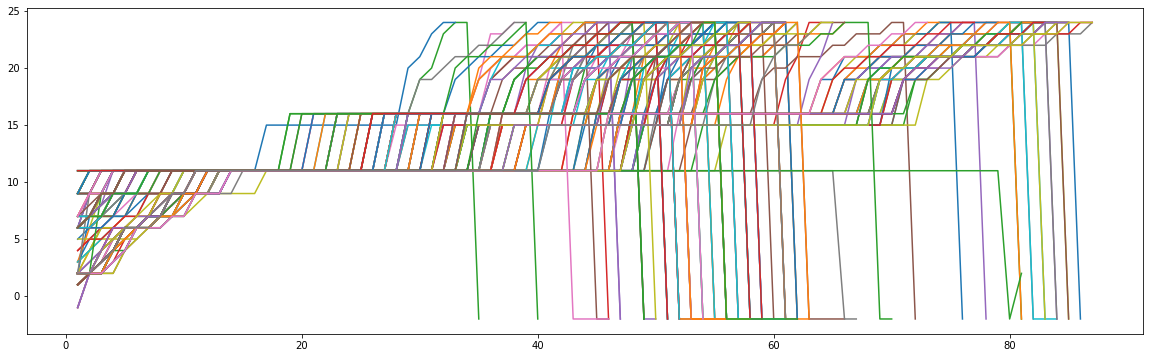

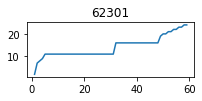

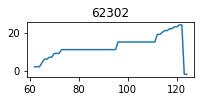

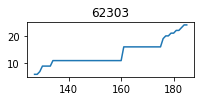

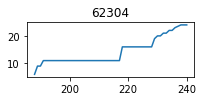

ETcatZBXS
     Run  ETcatZBXS
1  62301      500.0
2  62301      300.0
3  62301      300.0
4  62301     6200.0
5  62301     1400.0


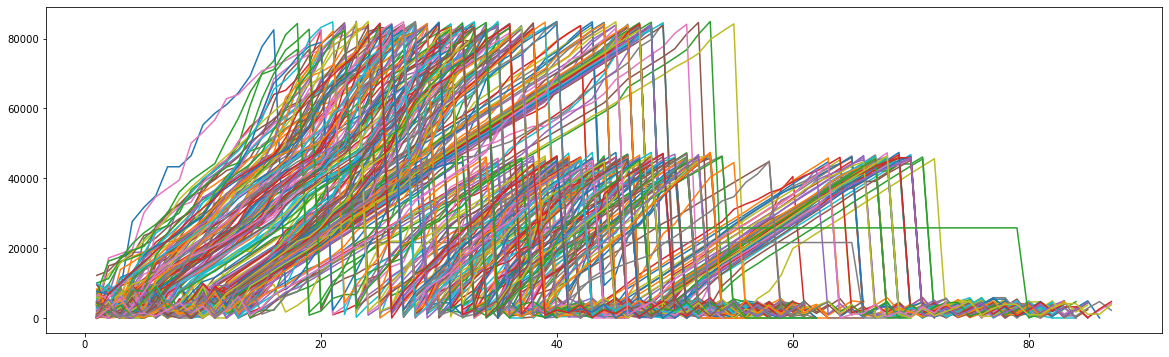

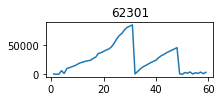

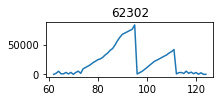

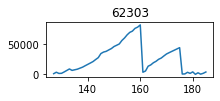

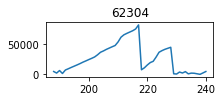

In [39]:
# Plot all other potential columns
check_columns = ['BmpcKiosIw', 'XnKsCBLOqH', 'SwpYipezsdueC', 'XAsiHMsvPv', 'RUNSjtpEAy', 'YATWcaRqpB', 'QesumGN', 'ETcatZBXS']
for check_column in check_columns:
    print(check_column)
    df_column=df
    for column in df.columns:
        if column != check_column and column != 'Run':
            df_column=df_column.drop(column, axis=1)
    #print(df_column.shape)
    print(df_column.head())
    # Split data into dicts by run number
    data_by_run = {run: df_column[df_column['Run'] == run] for run in runs}
    
    new_df = pd.DataFrame()
    i=0
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(20, 6))

    for run, df1 in data_by_run.items():
        i = i + 1
        # Exam the first new charts only
        #if i > 20:
        #    break
        y_data = df1[check_column]
        x_data = list(range(1, len(y_data) + 1))
        # Plot the first line
        ax.plot(x_data, y_data, label=run)

        # Print the first few chart individually
        if i < 5:
            fig2, ax2 = plt.subplots(figsize=(3, 1))
            ax2.set_title(run) 
            ax2.plot(y_data)
    plt.show()

Using the visual inspection above, we can select the two most potential patterns, **SwpYipezsdueC & QesumGN**, that are less irregular. We will go into the machine learning model training and hyperparameter tuning phase to test out the selected column/feature. From the visualisation, we can also see that each chart has a different length (x-axis) which we will need to resample for better machine-learning results. 

<h1>4. Hyperparameter tuning

Hyperparameter tuning will be combined into model training phase

<h1>5. Model Training & Hyperparameter tuning

In order to identify what is a good machine learning model to use, I explored a few modes: 
* KMean Clustering - Clustering works well, and RandomForest classification result is accurate. However, the KMean clustering result does not represent the actual observation result. Hence, this is not suitable (or maybe we need to fine-tune it?). The method used for KMean Clustering is documented in Appendix A.
* ARIMA -  Autoregressive Integrated Moving Average, is a widely used statistical method and a popular time series forecasting technique. The model has been tested, but some effort in tuning is required. The test result is included in Appendix B.
* DTW - Dynamic Time Warping (DTW) is a powerful algorithm for time series data analysis, and in this case, I will use this to compare two different sensor data from each of the Run. 
* Neural network - Autoencoder
* XGBoost - not tested
* Linear Regression - Based on the visualization output, it may not be suitable.

<h2>5.1 Testing DTW on column SwpYipezsdueC

In [40]:
# SwpYipezsdueC - Remove all columns except SwpYipezsdueC and Run column
df_check=df
check_column = 'SwpYipezsdueC'
for column in df.columns:
    if column != check_column and column != 'Run':
        df_check=df_check.drop(column, axis=1)
print(df.shape)
# Split data into dicts by run number
data_by_run = {run: df[df['Run'] == run] for run in runs}
df.head()

(13657, 51)


Run  DATA_QUALITY  LOT_ID  MachineRecipeID  PhysicalRecipeID  PortID  \
1  62301         63.49       1                1                 1       1   
2  62301         63.49       1                1                 1       1   
3  62301         63.49       1                1                 1       1   
4  62301         63.49       1                1                 1       1   
5  62301         63.49       1                1                 1       1   

   ProcessOpNum  ProductGrpID  ProductID  RECIPE_ID  ...  YATWcaRqpB  \
1             1             1          1          1  ...         0.0   
2             1             1          1          1  ...         5.0   
3             1             1          1          1  ...         4.0   
4             1             1          1          1  ...         3.0   
5             1             1          1          1  ...         2.0   

   nJdvUmCcjI  NACdQXDDBP  NyUITkJtCGK  QesumGN  ETcatZBXS  RnVvcKsHhDEyb  \
1         0.0         0.0         0.74      2.0      500.0           81.0   
2      1304.0      3110.0         0.74      7.0      300.0           81.0   
3      1305.0      3107.0         0.74      8.0      300.0           81.0   
4      1302.0      3104.0         0.74      9.0     6200.0           81.0   
5      1302.0      3103.0         0.74     11.0     1400.0           81.0   

   tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  CalcLoopSeq  
1                         -25.0          1.0          1.0  
2                        1890.0          2.0          2.0  
3                        1890.0          3.0          3.0  
4                        1890.0          4.0          4.0  
5                        1890.0          5.0          5.0  

[5 rows x 51 columns]

In [41]:
# SwpYipezsdueC - Get the max lenght for resampling
i=0
mydict={}
for run, df1 in data_by_run.items():
    i = i + 1
    mylist = df1[check_column].tolist()
    mydict[run]=len(mylist)
max_key = max(mydict, key=lambda key: mydict[key])
max_value = mydict[max_key]
print('Maximum Run record lenght =', max_value)

Maximum Run record lenght = 87


In [42]:
# SwpYipezsdueC - Convert column to rows and Resample the time series and put into new dataframe
new_df = pd.DataFrame()
i=0
for run, df1 in data_by_run.items():
    i = i + 1
    mylist = df1[check_column].tolist()
    # Resample mylist using linear interpolation to match the length of the longer list
    if len(mylist) < max_value:
        x1 = np.arange(len(mylist))
        x2 = np.linspace(0, len(mylist) - 1, max_value)
        mylist = np.interp(x2, x1, mylist)
    mylist = np.insert(mylist, 0, run)
    new_row = pd.DataFrame([mylist])
    new_df = pd.concat([new_df, new_row], ignore_index=True)
new_df.set_index(0, inplace=True)
print(new_df.shape)
new_df.head()

(228, 87)


1           2      3          4           5           6   \
0                                                                      
62301.0  125.0  123.697674  123.0  123.00000  123.000000  123.000000   
62302.0  120.0  120.000000  120.0  120.00000  120.000000  119.395349   
62303.0  121.0  121.000000  121.0  121.00000  121.000000  121.197674   
62304.0  123.0  123.000000  123.0  123.00000  123.000000  123.000000   
62305.0  120.0  120.000000  120.0  119.94186  119.255814  119.000000   

                 7           8           9           10  ...          78  \
0                                                        ...               
62301.0  123.000000  123.558140  124.000000  124.000000  ...  139.000000   
62302.0  119.000000  119.046512  119.767442  120.000000  ...  139.000000   
62303.0  121.837209  122.000000  122.116279  122.755814  ...  139.000000   
62304.0  123.488372  124.000000  124.000000  124.000000  ...  138.232558   
62305.0  119.116279  119.802326  120.000000  120.000000  ...  139.825581   

                 79          80          81          82          83  \
0                                                                     
62301.0  139.000000  139.000000  138.906977  138.255814  138.000000   
62302.0  138.767442  138.046512  138.000000  138.000000  138.000000   
62303.0  139.000000  139.000000  139.000000  139.000000  139.000000   
62304.0  138.000000  138.000000  138.000000  138.000000  138.000000   
62305.0  140.000000  139.802326  139.116279  139.000000  138.744186   

                 84          85         86     87  
0                                                  
62301.0  137.953488  137.302326  137.00000  137.0  
62302.0  138.000000  138.000000  137.44186  136.0  
62303.0  138.837209  137.558140  137.00000  137.0  
62304.0  138.000000  138.000000  138.00000  138.0  
62305.0  138.058140  138.000000  138.00000  138.0  

[5 rows x 87 columns]

In [44]:
# I'm using fastdtw module for the DTW function
!pip install fastdtw
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3582 sha256=a2f39d9ed9d8259fc0386d62ea07200bbd20f06dd3bd0a058fc2d61ebabaf3ad
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\1f\a1\63\bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


In [45]:
# Apply PCA before running DTW because the data is quite big and its very slow on normal computer
total_columns = new_df.shape[1]  # Get the total number of columns in the DataFrame
reduced = round(total_columns / 4)  # Divide by 4 and round to the nearest integer
print('Reduced to =',reduced)
index = new_df.index

# Create PCA model, Fit and transform data to 3 dimensions
pca = PCA(n_components=reduced) 
pca.fit(new_df)
df_pca = pca.transform(new_df)

# Recreate the df index
df_pca = pd.DataFrame(df_pca, index=index)
df_pca.head()

Reduced to = 22


0          1         2         3         4         5   \
0                                                                      
62301.0 -4.528732   4.598947 -1.816689  1.105305 -1.205897 -2.859194   
62302.0 -4.352126 -11.123944  6.751718  1.134868  0.175503 -0.756720   
62303.0 -4.326229  -1.472575  0.626259 -2.842489  1.128178  0.044000   
62304.0  0.323922   1.713296 -5.940478 -1.045901  1.502597 -0.100323   
62305.0  3.730851 -16.198990 -0.447203 -1.315915 -0.078253  0.370666   

               6         7         8         9   ...        12        13  \
0                                                ...                       
62301.0  0.809846 -1.002018 -0.554041 -0.296315  ... -0.188761  0.066872   
62302.0  0.305172 -1.697367 -0.852756 -1.175933  ...  0.421536  1.064678   
62303.0 -1.012148  0.712115  0.239125 -0.878084  ...  0.033840  0.076264   
62304.0  0.823538 -0.422371  1.368186 -1.083161  ...  1.463688 -0.490254   
62305.0 -0.215137  1.286064  1.289451 -0.453379  ... -0.286425 -1.252200   

               14        15        16        17        18        19        20  \
0                                                                               
62301.0  0.655117 -0.114671 -0.223312 -0.189307  0.129218 -0.906699 -0.216968   
62302.0 -1.239845  0.000208  0.664070  0.000062 -0.451144 -0.941742 -0.604475   
62303.0 -0.251440 -0.019097 -0.306030 -0.052171 -0.146005  0.286538 -0.759599   
62304.0 -0.047680 -1.132240  0.473502  0.442200  0.115340  0.504011 -0.182245   
62305.0 -0.012039  0.276966 -0.968814 -0.815291  0.449451 -0.311530  1.260871   

               21  
0                  
62301.0 -0.271155  
62302.0  0.073069  
62303.0  0.487333  
62304.0  0.710544  
62305.0  0.323023  

[5 rows x 22 columns]

In [50]:
# use fastdtw to calculate the distance between each time series
dtw_distances = []
df_dtw = pd.DataFrame()
df1 = df_pca
for index, row1 in df1.iterrows():
    #print(index)
    row_distances = []
    index_total_distance=0
    row1_flat = row1.to_numpy().flatten()
    for index2, row2 in df1.iterrows():
        row2_flat = row2.to_numpy().flatten()
        # Hyperparameter here can be furthre fine-tune for better accuraccy
        distance, _ = fastdtw(row1_flat, row2_flat, radius=5, dist=euclidean)
        row_distances.append(distance)
        index_total_distance=index_total_distance+distance
    dtw_distances.append(row_distances)
    print(index,'total=', index_total_distance)
    new_row = pd.DataFrame([[index, index_total_distance]])
    df_dtw = pd.concat([df_dtw, new_row], ignore_index=True)
    
df_dtw

62301.0 total= 6472.69094721733
62302.0 total= 7369.3169877427335
62303.0 total= 6674.9018258188735
62304.0 total= 7046.650287506865
62305.0 total= 8068.48644030589
62306.0 total= 7367.727784373192
62307.0 total= 7043.0460745038
62308.0 total= 7169.109524748203
62309.0 total= 7901.7567236714785
62318.0 total= 7252.47119689709
62319.0 total= 7046.873911736671
62320.0 total= 7177.900973192137
62321.0 total= 6244.013372074011
62322.0 total= 8307.1538585429
62323.0 total= 7857.689525944495
62324.0 total= 6372.478994356477
62325.0 total= 7091.079386112385
62326.0 total= 7220.560781948087
62327.0 total= 7680.8992623417025
62328.0 total= 8253.436082713877
62329.0 total= 10881.81854651849
62330.0 total= 8579.519339282602
62331.0 total= 7293.276950741867
62332.0 total= 13649.190120990814
62333.0 total= 7908.6897418525905
62334.0 total= 12072.408654824372
62335.0 total= 7500.0170096833945
62336.0 total= 8428.365633596195
62337.0 total= 7126.841201643487
62338.0 total= 6805.1770616576005
62339.0 

0            1
0    62301.0  6472.690947
1    62302.0  7369.316988
2    62303.0  6674.901826
3    62304.0  7046.650288
4    62305.0  8068.486440
..       ...          ...
223  62596.0  8315.799561
224  62597.0  7671.011028
225  62598.0  6650.195215
226  62599.0  8125.188334
227  62600.0  8215.820041

[228 rows x 2 columns]

In [58]:
# Review the result of the DTW distance calculation between all time series and try to identify potential abnormal patterns in some of the runs
df_dtw[1].describe()

count      228.000000
mean      8223.123234
std       4010.554753
min       6007.452694
25%       6853.710606
50%       7321.655432
75%       8037.527060
max      36885.021736
Name: 1, dtype: float64

In [322]:
# Review the result of the DTW distance calculation between all time series and try to identify potential abnormal patterns in some of the runs
df_dtw[1].describe()

count      228.000000
mean      8358.529401
std       3999.472676
min       6148.814517
25%       7001.162688
50%       7444.703551
75%       8188.359492
max      36926.013934
Name: 1, dtype: float64

In [59]:
# SwpYipezsdueC - From the 'describe' statistics, it seems most of the data are normal and below 95% quantiles
top_95_quantile = df_dtw[1].quantile(0.95)
print('Top 95 quantile =', top_95_quantile)
top_98_quantile = df_dtw[1].quantile(0.98)
print('Top 98 quantile =', top_98_quantile)

Top 95 quantile = 11918.807237771889
Top 98 quantile = 21326.230120636996


In [60]:
# SwpYipezsdueC - Show the Run numbers above 95% quantile
top_95_columns=df_dtw[df_dtw[1] > top_95_quantile]
top_95_columns

0             1
23   62332.0  13649.190121
25   62334.0  12072.408655
51   62360.0  12635.937154
114  62423.0  12891.975473
117  62426.0  36171.358584
118  62427.0  31934.787283
119  62428.0  31028.186718
126  62457.0  12919.226083
128  62459.0  12475.635413
132  62463.0  36885.021736
133  62464.0  30338.407512
182  62546.0  13541.856570

In [61]:
# SwpYipezsdueC - Show the Run numbers above 98% quantile
top_98_columns=df_dtw[df_dtw[1] > top_98_quantile]
top_98_columns

0             1
117  62426.0  36171.358584
118  62427.0  31934.787283
119  62428.0  31028.186718
132  62463.0  36885.021736
133  62464.0  30338.407512

In [63]:
# SwpYipezsdueC - Show the Run numbers below 5% quantile, these are Runs that matches most other Runs
bottom_1_quantile = df_dtw[1].quantile(0.1)
print('Bottom 1% quantile =', bottom_1_quantile)
bottom_1_columns=df_dtw[df_dtw[1] < bottom_1_quantile]
bottom_1_columns.head()

Bottom 1% quantile = 6495.190416440034


0            1
0   62301.0  6472.690947
12  62321.0  6244.013372
15  62324.0  6372.478994
44  62353.0  6411.187248
68  62377.0  6333.915840

<h2>5.2 DTW on column QesumGN

We can compare the result from this column to see if matching with the previous column or not

In [298]:
# QesumGN - Remove all columns except SwpYipezsdueC and Run column
df_check=df
check_column = 'QesumGN'
for column in df.columns:
    if column != check_column and column != 'Run':
        df_check=df_check.drop(column, axis=1)
print(df.shape)
# Split data into dicts by run number
data_by_run = {run: df[df['Run'] == run] for run in runs}
df.head()
# Get the max lenght for resampling
i=0
mydict={}
for run, df1 in data_by_run.items():
    i = i + 1
    mylist = df1[check_column].tolist()
    mydict[run]=len(mylist)
max_key = max(mydict, key=lambda key: mydict[key])
max_value = mydict[max_key]
print('Maximum Run record lenght =', max_value)
# Convert column to rows and Resample the time series and put into new dataframe
new_df = pd.DataFrame()
i=0
for run, df1 in data_by_run.items():
    i = i + 1
    mylist = df1[check_column].tolist()
    # Resample mylist using linear interpolation to match the length of the longer list
    if len(mylist) < max_value:
        x1 = np.arange(len(mylist))
        x2 = np.linspace(0, len(mylist) - 1, max_value)
        mylist = np.interp(x2, x1, mylist)
    mylist = np.insert(mylist, 0, run)
    new_row = pd.DataFrame([mylist])
    new_df = new_df.append(new_row, ignore_index=True)
new_df.set_index(0, inplace=True)
print(new_df.shape)
new_df.head()
# Apply DCA before running DTW because the data is quite big and its very slow on normal computer
total_columns = new_df.shape[1]  # Get the total number of columns in the DataFrame
reduced = round(total_columns / 4)  # Divide by 4 and round to the nearest integer
print('reduced=',reduced)
index = new_df.index

# Create PCA model, Fit and transform data to 3 dimensions
pca = PCA(n_components=reduced) 
pca.fit(new_df)
df_pca = pca.transform(new_df)

# Recreate the df index
df_pca = pd.DataFrame(df_pca, index=index)
df_pca.head()
# use fastdtw to calculate the distance between each time series
dtw_distances = []
df_dtw2 = pd.DataFrame()
df1 = df_pca
for index, row1 in df1.iterrows():
    #print(index)
    row_distances = []
    index_total_distance=0
    for index2, row2 in df1.iterrows():
        #print('2',index2)
        distance, _ = fastdtw(row1, row2, dist=euclidean)
        row_distances.append(distance)
        index_total_distance=index_total_distance+distance
        #print(index, '2', index2, distance)
    dtw_distances.append(row_distances)
    print(index,'total=', index_total_distance)
    new_row = pd.DataFrame([[index, index_total_distance]])
    df_dtw2 = df_dtw2.append(new_row, ignore_index=True)
    #print(df_dtw2)
df_dtw2

(13657, 51)
Maximum Run record lenght = 87


C:\Users\tklim\AppData\Local\Temp\ipykernel_17772\1855801585.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_row, ignore_index=True)


(228, 87)
reduced= 22
62301.0 total= 12132.630665316707


C:\Users\tklim\AppData\Local\Temp\ipykernel_17772\1855801585.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dtw2 = df_dtw2.append(new_row, ignore_index=True)


62302.0 total= 18206.11173113365
62303.0 total= 11656.213541331015
62304.0 total= 12534.289239028223
62305.0 total= 11792.127136143486
62306.0 total= 24033.772467991006
62307.0 total= 11831.726481891454
62308.0 total= 14701.9286860751
62309.0 total= 11603.54923868691
62318.0 total= 21902.702599699107
62319.0 total= 13104.441539519812
62320.0 total= 11429.451951893208
62321.0 total= 12989.291664257104
62322.0 total= 14626.697589917474
62323.0 total= 12530.380607910816
62324.0 total= 19021.028268496666
62325.0 total= 12059.232039236153
62326.0 total= 11137.226297952824
62327.0 total= 12316.508532840055
62328.0 total= 14379.505935164623
62329.0 total= 16159.600471269589
62330.0 total= 15221.043866883141
62331.0 total= 14752.458659154037
62332.0 total= 16087.538976894004
62333.0 total= 14221.822073588359
62334.0 total= 13561.110835329908
62335.0 total= 11190.924210729394
62336.0 total= 11717.50806902004
62337.0 total= 11377.982378823297
62338.0 total= 14226.63442882273
62339.0 total= 13336

0             1
0    62301.0  12132.630665
1    62302.0  18206.111731
2    62303.0  11656.213541
3    62304.0  12534.289239
4    62305.0  11792.127136
..       ...           ...
223  62596.0  12289.474816
224  62597.0  11039.461907
225  62598.0  12099.546353
226  62599.0  11484.771282
227  62600.0  14031.149875

[228 rows x 2 columns]

In [327]:
# QesumGN - Review the result of the DTW distance calculation between all time series and try to identify potential abnormal patterns in some of the runs
df_dtw2[1].describe()

count      228.000000
mean     13971.481204
std       4953.258976
min      10646.664245
25%      11482.045983
50%      12347.208949
75%      14026.315475
max      43160.288141
Name: 1, dtype: float64

In [328]:
# QesumGN - From the 'describe' statistics, it seems most of the data are normal and below 95% quantiles
top_95_quantile2 = df_dtw2[1].quantile(0.95)
print('Top 95 quantile2 =', top_95_quantile2)
top_98_quantile2 = df_dtw2[1].quantile(0.98)
print('Top 98 quantile2 =', top_98_quantile2)

Top 95 quantile2 = 24939.060376326845
Top 98 quantile2 = 33493.6810079262


In [329]:
# QesumGN - Show the Run numbers above 95% quantile
top_95_columns2=df_dtw2[df_dtw2[1] > top_95_quantile2]
top_95_columns2

0             1
97   62406.0  27480.667762
117  62426.0  26129.924097
118  62427.0  35252.349109
119  62428.0  37169.920273
132  62463.0  25919.600566
133  62464.0  33697.976500
141  62505.0  43160.288141
166  62530.0  33319.651514
169  62533.0  25426.523096
187  62551.0  25910.828785
211  62575.0  26174.794548
222  62586.0  38981.500588

In [330]:
# QesumGN - Show the Run numbers above 98% quantile
top_98_columns2=df_dtw2[df_dtw2[1] > top_98_quantile2]
top_98_columns2

0             1
118  62427.0  35252.349109
119  62428.0  37169.920273
133  62464.0  33697.976500
141  62505.0  43160.288141
222  62586.0  38981.500588

In [331]:
# Show the Run numbers below 5% quantile, these are Runs that matches most other Runs
bottom_1_quantile = df_dtw2[1].quantile(0.1)
print('Bottom 1% quantile =', bottom_1_quantile)
bottom_1_columns=df_dtw2[df_dtw2[1] < bottom_1_quantile]
bottom_1_columns.head()

Bottom 1% quantile = 11135.374801580703


0             1
33  62342.0  11079.086708
39  62348.0  11086.930209
42  62351.0  10854.708320
48  62357.0  10908.641310
60  62369.0  10912.357337

In [332]:
# Comparing both column
print(top_98_columns)
print(top_98_columns2)

           0             1
117  62426.0  36216.303689
118  62427.0  31983.703500
119  62428.0  31061.454015
132  62463.0  36926.013934
133  62464.0  30427.948838
           0             1
118  62427.0  35252.349109
119  62428.0  37169.920273
133  62464.0  33697.976500
141  62505.0  43160.288141
222  62586.0  38981.500588


<h4>Finding 4: Run 62427, 62428, 62464 seems to be abnormal consistently across both column/feature

In [333]:
# Comparing both column
print(top_95_columns)
print(top_95_columns2)

           0             1
23   62332.0  13818.202267
25   62334.0  12146.789453
51   62360.0  12702.098464
114  62423.0  13057.081765
117  62426.0  36216.303689
118  62427.0  31983.703500
119  62428.0  31061.454015
126  62457.0  13070.100589
128  62459.0  12556.636772
132  62463.0  36926.013934
133  62464.0  30427.948838
182  62546.0  13713.631782
           0             1
97   62406.0  27480.667762
117  62426.0  26129.924097
118  62427.0  35252.349109
119  62428.0  37169.920273
132  62463.0  25919.600566
133  62464.0  33697.976500
141  62505.0  43160.288141
166  62530.0  33319.651514
169  62533.0  25426.523096
187  62551.0  25910.828785
211  62575.0  26174.794548
222  62586.0  38981.500588


<h4>Finding 5: Run 62426, 62427, 62428, 62463, 62464 seems to be abnormal consistently across both column/feature SwpYipezsdueC & QesumGN

In [51]:
# Plot chart to verify the result
# Remove all columns except OunhHslCRwIRilo and Run column
mycolumn = 'SwpYipezsdueC'
df_column=df
for column in df.columns:
    if column != mycolumn and column != 'Run':
        df_column=df_column.drop(column, axis=1)
data_by_run = {run: df_column[df_column['Run'] == run] for run in runs}
print(df_column.shape)
df_column.head()

(13657, 2)


Run  SwpYipezsdueC
1  62301          125.0
2  62301          123.0
3  62301          123.0
4  62301          123.0
5  62301          123.0

62301
62426
62427
62428
62463
62464


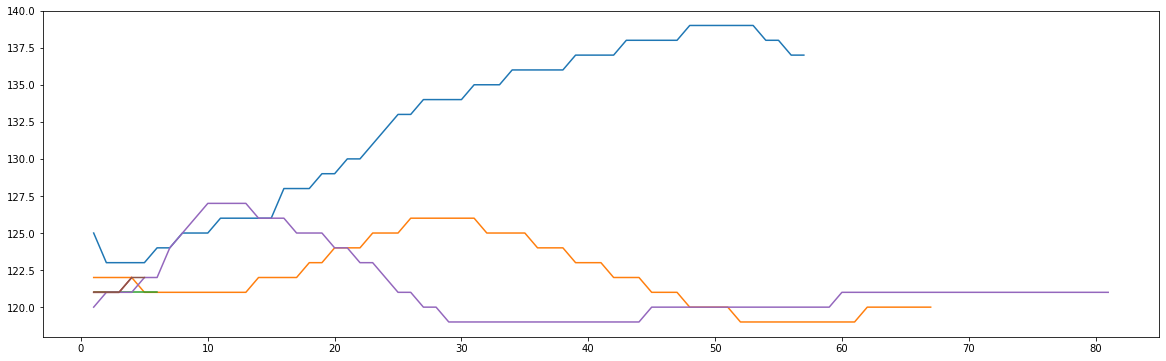

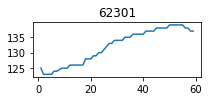

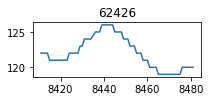

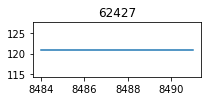

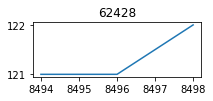

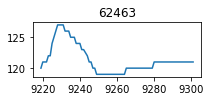

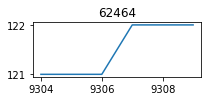

In [64]:
# Plot all the Runs with its pattern into single chart, and also into a few different chart
#import matplotlib.pyplot as plt2 
i=0
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

for run, df1 in data_by_run.items():
    #print(run)
    if run == 62301 or run == 62426 or run == 62427 or run == 62428 or run == 62463 or run == 62464:
        print(run)
        i = i + 1
        y_data = df1[mycolumn]
        x_data = list(range(1, len(y_data) + 1))
        ax.plot(x_data, y_data, label=run)

        # Create another figure
        fig2, ax2 = plt.subplots(figsize=(3, 1))
        ax2.set_title(run) 
        ax2.plot(y_data)
plt.show()

<h4>Finding 6: Run 62301 shows a normal pattern with least distance with other pattern. The rest of the chart shows abnormal pattern and that indicated likelihood of faulty sensor tool or other factors. 

<h1>Findings</h1>
* Finding 1: Found strange pattern around 8470 - 8500, around Run number 62426++<br>
* Finding 2: Found strange pattern around 9300-9310, Run number 62463+<br>
* Finding 3: Run number 62427, 62428, and 62464 has only less than seven rows or less than seven sensor data. This could mean the sensor tool is faulty as no data is coming from the sensor tool. <br>
* Finding 4: Run 62427, 62428, 62464 seems to be abnormal consistently across both column/feature (SwpYipezsdueC & QesumGN)<br>
* Finding 5: Run 62426, 62427, 62428, 62463, 62464 seems to be abnormal consistently across both column/feature (SwpYipezsdueC & QesumGN)<br>
* Finding 6: Run 62301 shows a normal pattern with least distance with other pattern. The rest of the chart shows abnormal pattern and that indicated likelihood of faulty sensor tool or other factors. <br>

<h1>Limitation, Challenges and Future improvement

Limited domain knowledge of the sensor tool can be of disadvantages to the AI Engineer. Hence, it is good to work with the process engineer or the sensor tool engineer to understand more about the process and the mechanics of the tool. Limitation of the computing resources, either CPU or GPU and slow down the ML learning process. Hence with the limited time, only a few ML model can be tested and limited number of data can be processed and trained. 


Challenges includes program debugging, python module conflicts (happens when installing tensorflow module), third party tools like fastdtw also faced problem with different version of the python modules. These are technical issues can be resolve with indepth troubleshooting.

Future improvement includes studying more ML models, testing with more ML models, especially using deep learning methods. This program also missed out a lot of hyperparameter tuning, data cleaning on outliers, noise and etc. With more time and resource, each column should be analyse in detail with the DTW model to identify more suitable columns/sensors that can be used to combine the result and provides a better accuracy. 

Additional improvement can be done is the current coding is unstructure, not build into classes or functions and difficult to deploy easily into other environment. All there can be improved with more understanding of the environment the coding need to be fitted into. 

<h1>Conclusion

The sample program above concluded that there are a few finding that can conclude there are certain Runs in the sample data consist of problematic or faulty sensor tool during the Runs. Data need to be validated and accuracy need to be recalculated and finetune to avoid high false positive alarm.

<h1>Appendices

<h2>Appendix A: Kmean Clustering Testing

In [198]:
#normaizing
from sklearn.preprocessing import StandardScaler
#take all rows and columns from second column onwards
df2 = df.values[:,0:]
print(df2)

[[63.49  1.    1.   ...  1.    1.    0.  ]
 [63.49  1.    1.   ...  2.    2.    0.  ]
 [63.49  1.    1.   ...  3.    3.    0.  ]
 ...
 [70.28 23.    1.   ... 11.   11.    0.  ]
 [70.28 23.    1.   ... 11.   11.    0.  ]
 [70.28 23.    1.   ... 12.   12.    0.  ]]


In [199]:
Clus_dataSet = StandardScaler().fit_transform(df2)
Clus_dataSet

array([[-0.46280422, -1.51789784, -0.52763326, ..., -1.73335486,
        -1.73335486, -0.93658517],
       [-0.46280422, -1.51789784, -0.52763326, ..., -1.3983402 ,
        -1.3983402 , -0.93658517],
       [-0.46280422, -1.51789784, -0.52763326, ..., -1.06332554,
        -1.06332554, -0.93658517],
       ...,
       [-0.02904233,  2.02262209, -0.52763326, ...,  1.61679174,
         1.61679174, -0.93658517],
       [-0.02904233,  2.02262209, -0.52763326, ...,  1.61679174,
         1.61679174, -0.93658517],
       [-0.02904233,  2.02262209, -0.52763326, ...,  1.9518064 ,
         1.9518064 , -0.93658517]])

In [200]:
# probably not necessary
df2 = np.nan_to_num(df2)
print(df2)

[[63.49  1.    1.   ...  1.    1.    0.  ]
 [63.49  1.    1.   ...  2.    2.    0.  ]
 [63.49  1.    1.   ...  3.    3.    0.  ]
 ...
 [70.28 23.    1.   ... 11.   11.    0.  ]
 [70.28 23.    1.   ... 11.   11.    0.  ]
 [70.28 23.    1.   ... 12.   12.    0.  ]]


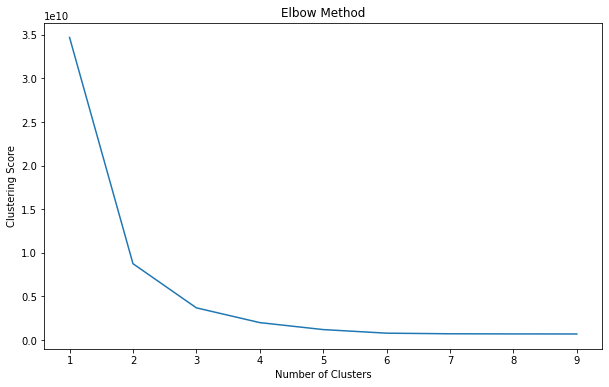

In [201]:
### ELBOW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
# Create a list of the number of clusters to try
n_clusters = range(1, 11)

# Perform KMeans clustering for each number of clusters
inertias = []
for i in n_clusters:
    kmeans = KMeans(n_clusters=i, init='random', random_state=42)
    kmeans.fit(df2)
    inertias.append(kmeans.inertia_)

# Plot the inertia of the clusters as a function of the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, inertias)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Score')
plt.show()

In [215]:
# Set the ClusterNum based on ELBOW test result
from sklearn.cluster import KMeans 
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df2)
labels = k_means.labels_
print(labels)

[2 3 3 ... 0 0 0]


In [216]:
df["Clus_km"] = labels
print(df.shape)
df.head(10)

(13652, 50)


DATA_QUALITY  LOT_ID  MachineRecipeID  PhysicalRecipeID  PortID  \
1          63.49       1                1                 1       1   
2          63.49       1                1                 1       1   
3          63.49       1                1                 1       1   
4          63.49       1                1                 1       1   
5          63.49       1                1                 1       1   
6          63.49       1                1                 1       1   
7          63.49       1                1                 1       1   
9          63.49       1                1                 1       1   
10         63.49       1                1                 1       1   
11         63.49       1                1                 1       1   

    ProcessOpNum  ProductGrpID  ProductID  RECIPE_ID  RouteID  ...  \
1              1             1          1          1        1  ...   
2              1             1          1          1        1  ...   
3              1             1          1          1        1  ...   
4              1             1          1          1        1  ...   
5              1             1          1          1        1  ...   
6              1             1          1          1        1  ...   
7              1             1          1          1        1  ...   
9              1             1          1          1        1  ...   
10             1             1          1          1        1  ...   
11             1             1          1          1        1  ...   

    YATWcaRqpB  nJdvUmCcjI  NACdQXDDBP  NyUITkJtCGK  QesumGN  RnVvcKsHhDEyb  \
1          0.0         0.0         0.0         0.74      2.0           81.0   
2          5.0      1304.0      3110.0         0.74      7.0           81.0   
3          4.0      1305.0      3107.0         0.74      8.0           81.0   
4          3.0      1302.0      3104.0         0.74      9.0           81.0   
5          2.0      1302.0      3103.0         0.74     11.0           81.0   
6          5.0      1304.0      3110.0         0.74     11.0           81.0   
7          5.0      1304.0      3110.0         0.74     11.0           81.0   
9          5.0      1306.0      3108.0         0.74     11.0           81.0   
10         5.0      1304.0      3108.0         0.74     11.0           81.0   
11         5.0      1305.0      3111.0         0.74     11.0           81.0   

    tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  CalcLoopSeq  Clus_km  
1                          -25.0          1.0          1.0        2  
2                         1890.0          2.0          2.0        3  
3                         1890.0          3.0          3.0        3  
4                         1890.0          4.0          4.0        3  
5                         1890.0          5.0          5.0        1  
6                         1890.0          5.0          5.0        1  
7                         1890.0          5.0          5.0        1  
9                         1890.0          5.0          5.0        1  
10                        1890.0          5.0          5.0        1  
11                        1890.0          5.0          5.0        1  

[10 rows x 50 columns]

In [217]:
print(df.loc[:, ['pIzvhgujbH', 'NACdQXDDBP', 'TyPUktVeQlH', 'Clus_km']])

       pIzvhgujbH  NACdQXDDBP  TyPUktVeQlH  Clus_km
1             1.0         0.0         13.0        2
2             1.0      3110.0        968.0        3
3             1.0      3107.0        968.0        3
4          1251.0      3104.0        968.0        3
5          2651.0      3103.0        968.0        1
...           ...         ...          ...      ...
14838       514.0      3108.0        953.0        3
14839         1.0      2013.0         14.0        0
14840         1.0      2005.0         14.0        0
14841         1.0      2005.0         14.0        0
14842         1.0      2003.0         14.0        0

[13652 rows x 4 columns]


In [218]:
df.groupby('Clus_km').mean()

DATA_QUALITY     LOT_ID  MachineRecipeID  PhysicalRecipeID    PortID  \
Clus_km                                                                         
0           71.438206  10.552309         1.246055          1.246055  1.410286   
1           70.468719  10.408682         1.213912          1.213912  1.429707   
2           70.770082  10.736735         1.194898          1.194898  1.364286   
3           71.664989  10.229836         1.225553          1.225553  1.407566   

         ProcessOpNum  ProductGrpID  ProductID  RECIPE_ID   RouteID  ...  \
Clus_km                                                              ...   
0            1.939801      5.939801   6.709527   1.003507  5.157802  ...   
1            1.942364      5.919247   6.685146   1.000000  5.127301  ...   
2            1.921429      6.312245   7.090816   1.009184  5.488776  ...   
3            1.867238      5.785153   6.513205   1.000000  5.084226  ...   

         RUNSjtpEAy  YATWcaRqpB   nJdvUmCcjI   NACdQXDDBP  NyUITkJtCGK  \
Clus_km                                                                  
0          3.023378    3.138515   990.042081  1990.989480         0.74   
1          6.868828    3.250418  1304.030230  3106.261925         0.74   
2          6.077551    7.115306    85.468367    68.265306         0.74   
3          8.672377    4.470378  1291.082798  3076.641685         0.74   

           QesumGN  RnVvcKsHhDEyb  tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  \
Clus_km                                                                        
0        21.014611      96.272355                   1841.414378     9.549971   
1        12.754079      96.062343                   1890.000000     5.690272   
2        10.775510      96.259184                   1233.525510     7.184694   
3         9.718772      95.645967                   1890.000000     4.644540   

         CalcLoopSeq  
Clus_km               
0           9.549971  
1           5.690272  
2           7.184694  
3           4.644540  

[4 rows x 49 columns]

In [221]:
df.to_csv('d:\\download\\preproc_kmean4.csv', index=False)

In [220]:
print('0',(df['Clus_km'] == 0).sum())
print('1',(df['Clus_km'] == 1).sum())
print('2',(df['Clus_km'] == 2).sum())
print('3',(df['Clus_km'] == 3).sum())

0 1711
1 9560
2 980
3 1401


2135

In [181]:
# Validating the KMean data, programs below may not execute correct here as it is merged from another program
df = pd.read_csv('D:\\Download\\post_kmean.csv')
df.head()

4724

In [ ]:
column_stddev = {}
for column in df.columns:
    std_deviation = df[column].std()
    print(column, std_deviation)
    if std_deviation == 0:
        df = df.drop(column, axis=1)
        #df.drop(column, inplace=True, axis=1)
    else:
        column_stddev[column]=std_deviation

In [ ]:
NAs = pd.concat([df.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

In [ ]:
for col in df.dtypes[df.dtypes == "object"].index:
    for_dummy = df.pop(col)
    df = pd.concat([train.pd.get_dummies(for_dummy, prefix=col)], axis=1)
df.head()

In [ ]:
labels = df.pop("Clus_km")
df.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

In [ ]:
y_pred = rf.predict(x_test)
print(y_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
n_estimators = [1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20]
train_results=[]
test_results=[]

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt 

linel, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

<h2>Appendix B: ARIMA Model

This is a partial code that is not runable. This is just an illustration of how ARIMA model been tested and found difficult to fine-tune to work correctly

In [ ]:
# Analyze each run's data frame separately
# Import the library 
from pmdarima import auto_arima
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

i = 0
df_old=pd.DataFrame()
for run, df1 in data_by_run.items():
    print(f"Analyzing Run {run}")
    i = i + 1
    if i > 5:
        break

    plt.figure(figsize=(15, 2))
    x_data = list(range(1, len(df1['QesumGN']) + 1))
    plt.scatter(x_data, df1['QesumGN'], marker='.', color='blue', label=run)
    plt.title(run)
    plt.show()
    
    df2=df1.drop('Run', axis=1)
    df2_train = df2
    if df_old.shape[0] == 0:
        print('dfold=df1')
        df_old=df2
        df2_auto_arima_old = auto_arima(df2, stepwise=False, seasonal=False)
    df2_test = df_old
    print(len(df2_train))
    print(len(df2_test))

    df2_auto_arima = auto_arima(df2_train, stepwise=False, seasonal=False)
    print(df2_auto_arima)
    print(df2_auto_arima.summary())
    
    if df_old.shape[0] == 0:
        print('dfold=df1')
        df_old=df2
        df2_auto_arima_old=df2_auto_arima
    print(df2_auto_arima_old)
    print(df2_auto_arima_old.summary())
    
    df2_auto_arima.plot_diagnostics()
    df2_auto_arima_old.plot_diagnostics()

    #forecast_test_auto = df2_auto_arima.predict(n_periods=len(df2_train))
    #print(forecast_test_auto.head())
    #df2['forecast_auto'] = [None]*len(df2_train) + list(forecast_test_auto)
    #forecast_test_auto.plot()
    
    df2_auto_arima_old=df2_auto_arima
    df_old=df2
    

In [ ]:
# Output
dfold=df1
57
57
 ARIMA(0,1,0)(0,0,0)[0] intercept
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -82.019
Date:                Thu, 02 Nov 2023   AIC                            168.037
Time:                        12:47:55   BIC                            172.088
Sample:                             0   HQIC                           169.608
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3929      0.371      1.059      0.290      -0.334       1.120
sigma2         1.0957      0.214      5.128      0.000       0.677       1.514
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               399.59
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             3.37
Prob(H) (two-sided):                  0.05   Kurtosis:                        14.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
 ARIMA(0,1,0)(0,0,0)[0] intercept
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -82.019
Date:                Thu, 02 Nov 2023   AIC                            168.037
Time:                        12:47:56   BIC                            172.088
Sample:                             0   HQIC                           169.608
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3929      0.371      1.059      0.290      -0.334       1.120
sigma2         1.0957      0.214      5.128      0.000       0.677       1.514
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               399.59
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             3.37
Prob(H) (two-sided):                  0.05   Kurtosis:                        14.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
Analyzing Run 62302